In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Task 1: Dataset Exploration

Experimenting with the training data, trying to find patterns.

In [5]:
df=pd.read_csv('train.txt',sep=' ')

In [6]:
print(df)

          person1         relation      person2
0         olivia0         sisterOf     selina10
1         olivia0         sisterOf   isabella11
2         olivia0         sisterOf      oskar24
3         olivia0         sisterOf        adam9
4         olivia0     secondAuntOf       lena18
...           ...              ...          ...
13816  moritz1298  greatGrandsonOf   daniel1309
13817  moritz1298         nephewOf    emily1312
13818  moritz1298         nephewOf    jakob1293
13819  moritz1298         fatherOf      leo1304
13820     jan1299         fatherOf  claudia1300

[13821 rows x 3 columns]


In [7]:
df.keys()

Index(['person1', 'relation', 'person2'], dtype='object')

In [8]:
print('Number of distinct people in left column',df['person1'].nunique())
unique_p1=df['person1'].unique()
print(unique_p1)

Number of distinct people in left column 1316
['olivia0' 'katharina1' 'selina10' ... 'anna1297' 'moritz1298' 'jan1299']


In [9]:
print('Number of distinct people in right column',df['person2'].nunique())
unique_p2=df['person2'].unique()
print(unique_p2)

Number of distinct people in right column 1304
['selina10' 'isabella11' 'oskar24' ... 'samuel1310' 'adrian1314' 'mia1301']


In [10]:
intersect = pd.Series(np.intersect1d(unique_p1, unique_p2))
print(intersect)

0         adam1073
1          adam125
2         adam1281
3          adam198
4          adam306
           ...    
1298    vincent704
1299     vincent79
1300    vincent792
1301    vincent848
1302    vincent973
Length: 1303, dtype: object


In [11]:
union = pd.Series(np.union1d(unique_p1, unique_p2))
print(union)

0         adam1073
1          adam125
2         adam1281
3          adam198
4          adam306
           ...    
1312    vincent704
1313     vincent79
1314    vincent792
1315    vincent848
1316    vincent973
Length: 1317, dtype: object


In [12]:
isolated=np.setdiff1d(union,intersect)
print(isolated)
print(np.setdiff1d(unique_p2,intersect))
isolated_p1=np.setdiff1d(unique_p1,intersect)
print(isolated_p1)

['elena55.DS_Stor' 'hannah777' 'lea1254' 'luis1014' 'luis799' 'marcel700'
 'natalie1096' 'nico1231' 'nina730' 'sebastian1209' 'sophie1039'
 'tobias1011' 'valentin1234' 'valentina1303']
['elena55.DS_Stor']
['hannah777' 'lea1254' 'luis1014' 'luis799' 'marcel700' 'natalie1096'
 'nico1231' 'nina730' 'sebastian1209' 'sophie1039' 'tobias1011'
 'valentin1234' 'valentina1303']


In [13]:
print(df[df['person2']=='elena55.DS_Stor'])
for i in isolated_p1:
    print(df.query('person1 == @i'))

       person1 relation          person2
689  philipp70  uncleOf  elena55.DS_Stor
        person1  relation     person2
8056  hannah777  motherOf  natalie778
8057  hannah777  motherOf  vanessa783
       person1  relation    person2
13017  lea1254  motherOf  felix1255
        person1  relation        person2
10394  luis1014  fatherOf  valentina1015
10395  luis1014  fatherOf     leonie1016
      person1  relation   person2
8294  luis799  fatherOf  marie800
        person1  relation  person2
7258  marcel700  fatherOf  luis701
           person1  relation        person2
11414  natalie1096  motherOf  charlotte1097
        person1  relation   person2
12746  nico1231  fatherOf  noah1232
      person1  relation   person2
7560  nina730  motherOf  felix731
             person1  relation     person2
12474  sebastian1209  fatherOf  lorenz1210
          person1  relation         person2
10737  sophie1039  motherOf  maximilian1040
          person1  relation     person2
10355  tobias1011  fatherOf  

In [14]:
relations=df['relation'].unique()
print(relations)

['sisterOf' 'secondAuntOf' 'girlCousinOf' 'daughterOf' 'granddaughterOf'
 'nieceOf' 'motherOf' 'greatAuntOf' 'grandmotherOf' 'auntOf' 'uncleOf'
 'greatUncleOf' 'brotherOf' 'sonOf' 'fatherOf' 'grandfatherOf'
 'secondUncleOf' 'boyCousinOf' 'grandsonOf' 'nephewOf'
 'girlSecondCousinOf' 'girlFirstCousinOnceRemovedOf'
 'greatGranddaughterOf' 'greatGrandmotherOf' 'greatGrandfatherOf'
 'boySecondCousinOf' 'boyFirstCousinOnceRemovedOf' 'greatGrandsonOf']


In [15]:
relation_counts=df['relation'].value_counts()
relation_counts=relation_counts.values

In [16]:
print(relation_counts)

[814 813 813 812 733 733 636 628 624 617 617 610 600 570 556 514 496 454
 445 391 312 237 180 175 158 153  68  62]


## Plotting relation type frequencies to see if there's some insight

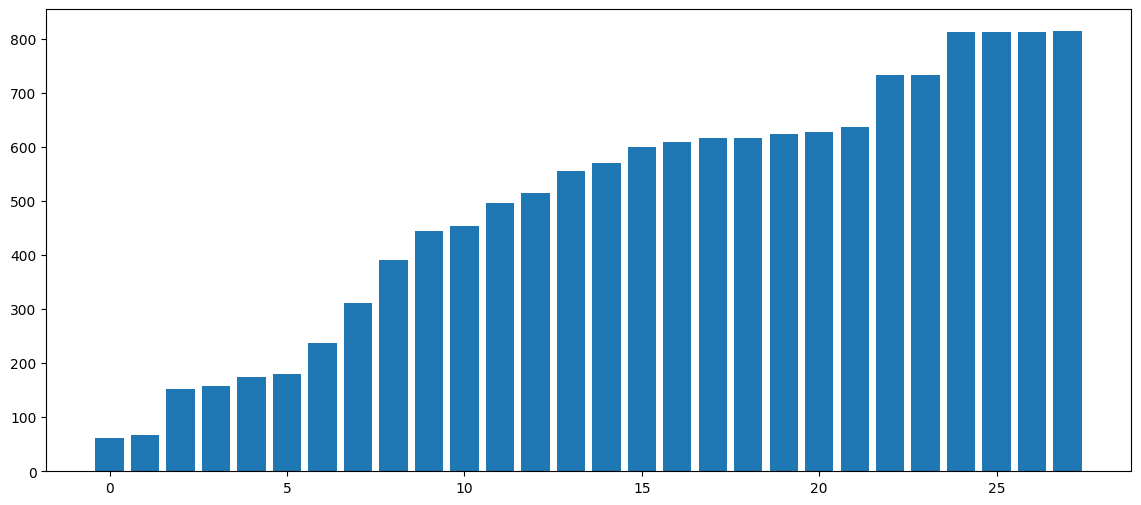

In [17]:
plt.figure(figsize=(14, 6))
plt.bar(range(len(relation_counts)), sorted(relation_counts))
plt.show()


It may be useful to know what are the different unique relationships we are dealing with as well as their frequencies. 
We also need to check whether all the edges we have are consistent. For example, detecting faulty relationships like some person
being someone else's newphew but the latter not being the person's uncle/aunt. Also the degree of each node can help us identify 
any isolated ones.
An idea about how to go about analyzing the graph is to assign a weight to the edge for a particular relation based on how 
close in dna resemblance both people are. For example, assigning w to father and w/2 to grandfather.

In [18]:
degree_count=df['person1'].value_counts()
print(degree_count)

person1
olivia1043       22
lisa1035         22
oliver1045       22
magdalena1044    22
dominik1036      22
                 ..
charlotte945      1
valentina25       1
mia17             1
adrian1314        1
jan1299           1
Name: count, Length: 1316, dtype: int64


The nodes with lower degree may, with high probability, be in the topmost part or bottom most part of the graph,
especially if the relations it has are grandfatherof or grandsonof, or they could be bridges. We come to know these may not the center of the lineage
as they are either the start, or the end of a particular generation, given the dataset.

In [19]:
print(union)
name_to_id = {name: i for i, name in enumerate(union)}
print(name_to_id)


0         adam1073
1          adam125
2         adam1281
3          adam198
4          adam306
           ...    
1312    vincent704
1313     vincent79
1314    vincent792
1315    vincent848
1316    vincent973
Length: 1317, dtype: object
{'adam1073': 0, 'adam125': 1, 'adam1281': 2, 'adam198': 3, 'adam306': 4, 'adam359': 5, 'adam426': 6, 'adam474': 7, 'adam627': 8, 'adam719': 9, 'adam892': 10, 'adam9': 11, 'adrian1314': 12, 'adrian155': 13, 'adrian213': 14, 'adrian303': 15, 'adrian330': 16, 'adrian397': 17, 'adrian535': 18, 'adrian735': 19, 'adrian856': 20, 'adrian870': 21, 'alexander1052': 22, 'alexander1066': 23, 'alexander1142': 24, 'alexander137': 25, 'alexander195': 26, 'alexander325': 27, 'alexander573': 28, 'alexander795': 29, 'alexander820': 30, 'alexander981': 31, 'alina1124': 32, 'alina123': 33, 'alina1263': 34, 'alina1296': 35, 'alina156': 36, 'alina173': 37, 'alina32': 38, 'alina371': 39, 'alina482': 40, 'alina671': 41, 'alina762': 42, 'alina957': 43, 'amelie1141': 44, 'ameli

## Constructing the main graph

In [20]:
main_graph=nx.DiGraph()

In [21]:
print(relations)
dna_weights = {
    # --- 1st Degree (50% shared) ---
    'fatherOf': 0.5, 'motherOf': 0.5,
    'sonOf': 0.5, 'daughterOf': 0.5,
    'brotherOf': 0.5, 'sisterOf': 0.5,

    # --- 2nd Degree (25% shared) ---
    'grandfatherOf': 0.25, 'grandmotherOf': 0.25,
    'grandsonOf': 0.25, 'granddaughterOf': 0.25,
    'uncleOf': 0.25, 'auntOf': 0.25,
    'nephewOf': 0.25, 'nieceOf': 0.25,

    # --- 3rd Degree (12.5% shared) ---
    'greatGrandfatherOf': 0.125, 'greatGrandmotherOf': 0.125,
    'greatGrandsonOf': 0.125, 'greatGranddaughterOf': 0.125,
    'greatUncleOf': 0.125, 'greatAuntOf': 0.125,
    # First Cousins share 12.5%
    'boyCousinOf': 0.125, 'girlCousinOf': 0.125,

    # --- 4th Degree (6.25% shared) ---
    # "First Cousin Once Removed" (Child of your first cousin OR First cousin of your parent)
    'boyFirstCousinOnceRemovedOf': 0.0625, 'girlFirstCousinOnceRemovedOf': 0.0625,
    # "Second Uncle/Aunt" typically implies the First Cousin of your parent
    'secondUncleOf': 0.0625, 'secondAuntOf': 0.0625,

    # --- 5th Degree (3.125% shared) ---
    # Second Cousins (Children of first cousins)
    'boySecondCousinOf': 0.03125, 'girlSecondCousinOf': 0.03125
}

['sisterOf' 'secondAuntOf' 'girlCousinOf' 'daughterOf' 'granddaughterOf'
 'nieceOf' 'motherOf' 'greatAuntOf' 'grandmotherOf' 'auntOf' 'uncleOf'
 'greatUncleOf' 'brotherOf' 'sonOf' 'fatherOf' 'grandfatherOf'
 'secondUncleOf' 'boyCousinOf' 'grandsonOf' 'nephewOf'
 'girlSecondCousinOf' 'girlFirstCousinOnceRemovedOf'
 'greatGranddaughterOf' 'greatGrandmotherOf' 'greatGrandfatherOf'
 'boySecondCousinOf' 'boyFirstCousinOnceRemovedOf' 'greatGrandsonOf']


Generated weights based on percentage of dna shared. Idea of using these weights is inspired from
https://www.genetic-genealogy.co.uk/Toc115570135.html.

## Mapping relations to id and adding edges

In [22]:
unique_relations = df['relation'].unique()
relation_to_id = {rel: i for i, rel in enumerate(unique_relations)}

print("Relation ID Mapping:")
for rel, rid in relation_to_id.items():
    print(f"{rid}: {rel}")

for row in df.itertuples():
    w = dna_weights.get(row.relation, 0.0) 
    
    r_id = relation_to_id[row.relation]
    
    main_graph.add_edge(row.person1, row.person2, weight=w, relation_id=r_id)

Relation ID Mapping:
0: sisterOf
1: secondAuntOf
2: girlCousinOf
3: daughterOf
4: granddaughterOf
5: nieceOf
6: motherOf
7: greatAuntOf
8: grandmotherOf
9: auntOf
10: uncleOf
11: greatUncleOf
12: brotherOf
13: sonOf
14: fatherOf
15: grandfatherOf
16: secondUncleOf
17: boyCousinOf
18: grandsonOf
19: nephewOf
20: girlSecondCousinOf
21: girlFirstCousinOnceRemovedOf
22: greatGranddaughterOf
23: greatGrandmotherOf
24: greatGrandfatherOf
25: boySecondCousinOf
26: boyFirstCousinOnceRemovedOf
27: greatGrandsonOf


In [23]:
id_to_relation={i : rel  for i, rel in enumerate(unique_relations)}


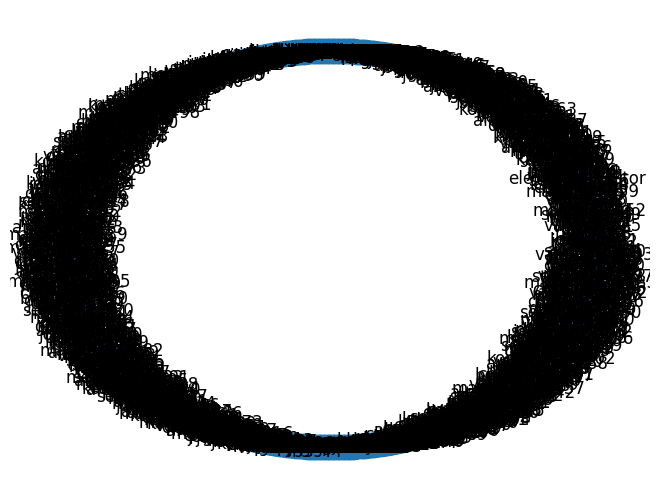

In [24]:
nx.draw_circular(main_graph, with_labels=True)
plt.show()

In [25]:
main_graph.in_degree()

InDegreeView({'olivia0': 19, 'selina10': 21, 'isabella11': 21, 'oskar24': 21, 'adam9': 21, 'lena18': 20, 'fabian26': 20, 'leon16': 19, 'johanna22': 19, 'jonas23': 17, 'katharina1': 14, 'dominik2': 10, 'ella19': 9, 'david20': 9, 'emma7': 17, 'moritz8': 17, 'paula12': 14, 'natalie13': 13, 'luis14': 14, 'lisa5': 22, 'elias6': 22, 'nico4': 20, 'emily15': 2, 'mia17': 1, 'vincent21': 3, 'valentina25': 1, 'oliver3': 3, 'marcel27': 14, 'tobias37': 8, 'beate36': 8, 'karin41': 3, 'thomas42': 3, 'ella45': 3, 'elias46': 3, 'raphael29': 20, 'marlene40': 12, 'marie43': 14, 'sebastian49': 14, 'moritz31': 14, 'hannah39': 13, 'dominik44': 11, 'magdalena52': 11, 'sofia28': 13, 'alina32': 6, 'luca33': 7, 'clara34': 4, 'luis35': 4, 'paula50': 4, 'maria38': 4, 'luisa47': 3, 'marko48': 3, 'victoria30': 7, 'lukas51': 1, 'victoria53': 11, 'nico63': 9, 'amelie62': 9, 'elena55': 16, 'felix65': 17, 'claudia69': 20, 'oliver71': 17, 'jakob78': 17, 'tobias57': 21, 'magdalena59': 21, 'raphael73': 15, 'simon54': 11, 

## Visualizing the Graph in Gephi

In [26]:
G_export = main_graph.copy()

for node, data in G_export.nodes(data=True):
    for key, val in data.items():
        if isinstance(val, (list, set, dict)):
            data[key] = str(val)  # Convert lists to strings
        if val is None:
            data[key] = ""        # Replace None with empty string

for u, v, data in G_export.edges(data=True):
    for key, val in data.items():
        if isinstance(val, (list, set, dict)):
            data[key] = str(val)
        if val is None:
            data[key] = ""

nx.write_gexf(G_export, "family_network.gexf")

![alt text](/home/kushagra-agrawal/Desktop/precog_task/gephi_viz.png)

## Plotting a subgraph

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def generate_distinct_colors(n):
    palettes = ['tab20', 'tab20b', 'tab20c']
    colors = []
    for p in palettes:
        cmap = cm.get_cmap(p, 20)
        colors.extend([mcolors.to_hex(cmap(i)) for i in range(20)])
    return colors[:n]



import matplotlib.patches as mpatches

def draw_relational_colored_edges(G, start_node, radius=3, special_pairs=None):
    """
    G: The graph
    start_node: The center node
    radius: How many steps out to include
    special_pairs: A list of tuples for complementary relations which should be colored distinctly
                   e.g., [('fatherOf', 'sonOf'), ('motherOf', 'daughterOf')]
    """
    
    # 1. EXTRACT Subgraph
    if start_node not in G:
        print(f"Node {start_node} not found.")
        return
        
    subgraph = nx.ego_graph(G, start_node, radius=radius)
    
    # 2. LAYOUT: Concentric Shells (Hierarchy)
    # Group nodes by distance from center
    distances = nx.single_source_shortest_path_length(subgraph, start_node)
    max_dist = max(distances.values())
    layers = [[] for _ in range(max_dist + 1)]
    for n, d in distances.items():
        layers[d].append(n)
    
    pos = nx.shell_layout(subgraph, nlist=layers)

    # 3. COLOR LOGIC: Relation-Based
    # Extract all unique relations in this subgraph
    # We prioritize 'relation_name', fall back to 'relation_id'
    unique_relations = set()
    for u, v, data in subgraph.edges(data=True):
        # Fetch attribute, default to 'unknown'
        r = data.get('relation_name', data.get('relation_id', 'unknown'))
        unique_relations.add(r)
    
    # Define a base palette of distinct colors
    base_palette = generate_distinct_colors(len(unique_relations))

    
    relation_color_map = {}
    palette_index = 0
    
    # Handle "Special Pairs" (Complementary Connections) first
    # We assign them high-contrast colors manually
    if special_pairs:
        contrast_sets = [
            ('#FF0000', '#0000FF'), # Red vs Blue
            ('#00FF00', '#800080'), # Lime vs Purple
            ('#FFA500', '#00FFFF'), # Orange vs Cyan
        ]
        
        for i, (rel_a, rel_b) in enumerate(special_pairs):
            if rel_a in unique_relations or rel_b in unique_relations:
                # Pick a contrast set (cycle if needed)
                c1, c2 = contrast_sets[i % len(contrast_sets)]
                relation_color_map[rel_a] = c1
                relation_color_map[rel_b] = c2

    # Assign colors to remaining relations
    for rel in unique_relations:
        if rel not in relation_color_map:
            relation_color_map[rel] = base_palette[palette_index % len(base_palette)]
            palette_index += 1

    # 4. PREPARE DRAWING DATA
    edge_colors = []
    edges_to_draw = []
    
    for u, v, data in subgraph.edges(data=True):
        r = data.get('relation_name', data.get('relation_id', 'unknown'))
        edges_to_draw.append((u, v))
        edge_colors.append(relation_color_map.get(r, 'black'))

    # 5. DRAW
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Draw Edges
    if edges_to_draw:
        nx.draw_networkx_edges(subgraph, pos, 
                               edgelist=edges_to_draw,
                               edge_color=edge_colors,
                               width=2,
                               connectionstyle="arc3,rad=0.1",
                               arrowstyle='-|>', 
                               arrowsize=15,
                               ax=ax)
    
    # Draw Nodes
    nx.draw_networkx_nodes(subgraph, pos, nodelist=subgraph.nodes(),
                           node_color='white', edgecolors='black', node_size=500,
                           ax=ax)
    
    nx.draw_networkx_labels(subgraph, pos, font_size=9, ax=ax)
    
    # Highlight Center
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[start_node], 
                           node_color='gold', node_size=700, edgecolors='black',
                           ax=ax)

    # Custom Legend for Relations
    legend_handles = []
    for rel, color in relation_color_map.items():
        # Only add to legend if this relation actually appears in the subgraph
        if rel in unique_relations:
            patch = mpatches.Patch(color=color, label=str(rel))
            legend_handles.append(patch)
            
    ax.legend(handles=legend_handles, loc='upper right', title="Relations")
    ax.set_title(f"Relation-Based Coloring: {start_node}")
    ax.axis('off')
    plt.show()

/tmp/ipykernel_1633744/1526464323.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(p, 20)


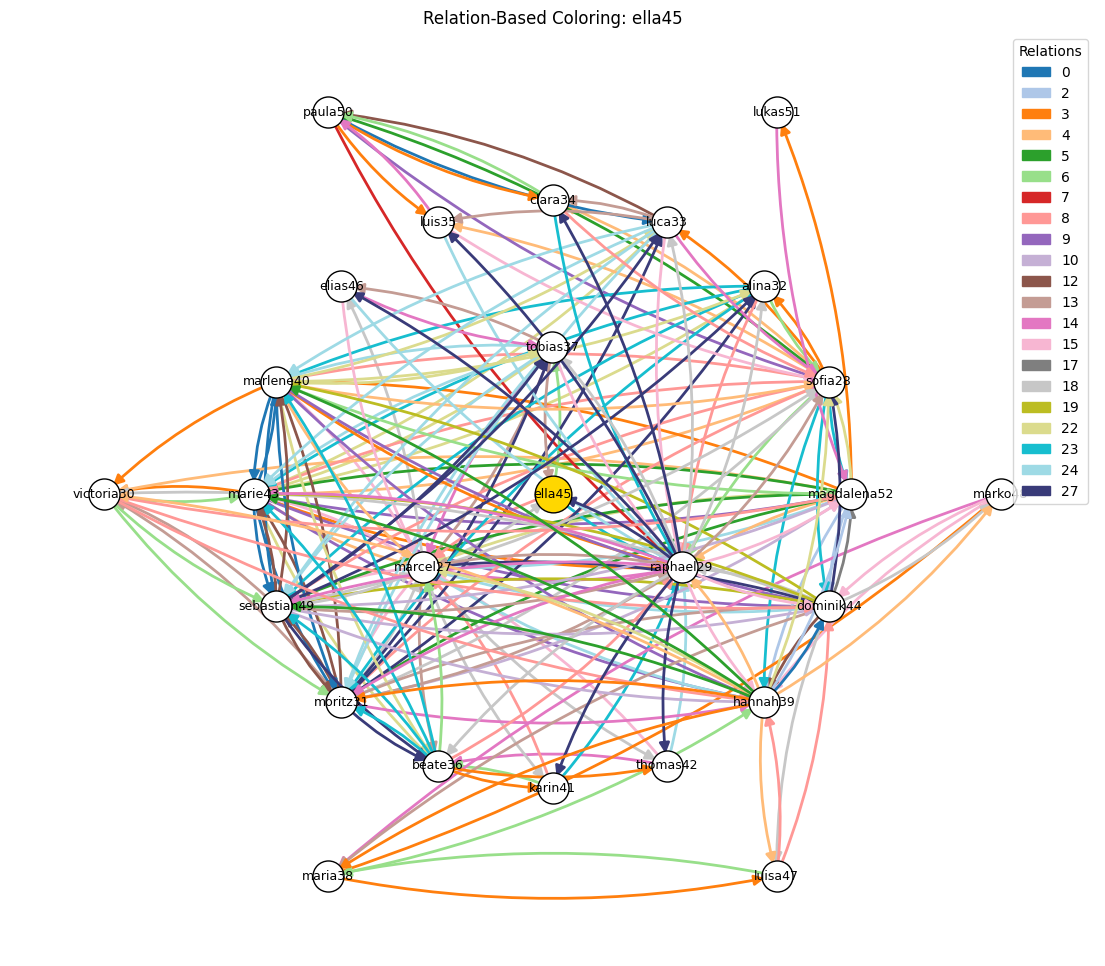

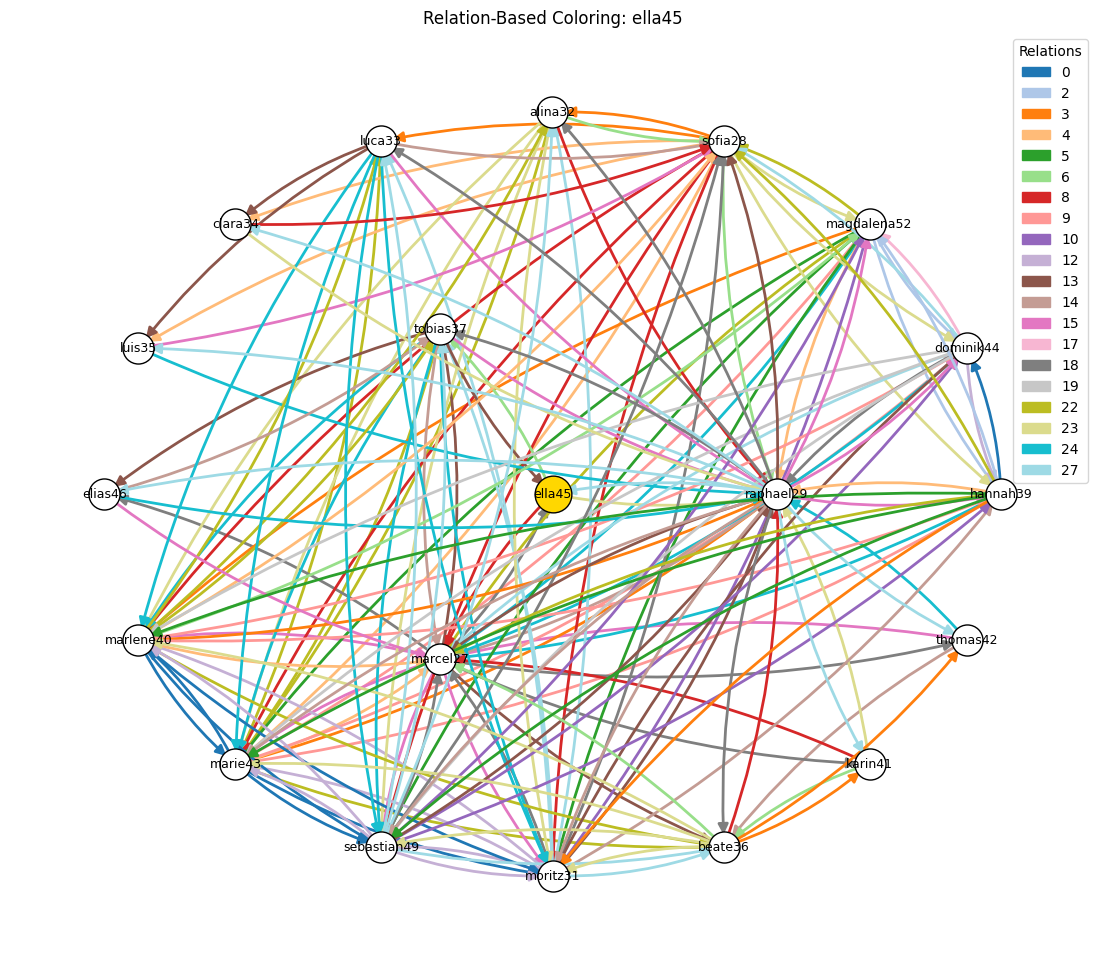

{'sisterOf': 0, 'secondAuntOf': 1, 'girlCousinOf': 2, 'daughterOf': 3, 'granddaughterOf': 4, 'nieceOf': 5, 'motherOf': 6, 'greatAuntOf': 7, 'grandmotherOf': 8, 'auntOf': 9, 'uncleOf': 10, 'greatUncleOf': 11, 'brotherOf': 12, 'sonOf': 13, 'fatherOf': 14, 'grandfatherOf': 15, 'secondUncleOf': 16, 'boyCousinOf': 17, 'grandsonOf': 18, 'nephewOf': 19, 'girlSecondCousinOf': 20, 'girlFirstCousinOnceRemovedOf': 21, 'greatGranddaughterOf': 22, 'greatGrandmotherOf': 23, 'greatGrandfatherOf': 24, 'boySecondCousinOf': 25, 'boyFirstCousinOnceRemovedOf': 26, 'greatGrandsonOf': 27}


In [28]:
draw_relational_colored_edges(main_graph,"ella45",3)
draw_relational_colored_edges(main_graph,"ella45",2)
print(relation_to_id)

Chose this particular node for the ego graph, as it has an in-degree of 3, which is neither extremely high, nor insignificant.
Extremely high indegree/outdegree nodes are the ones with high degree                                                                centrality and given the dense network we have been given, 
difficult to visualize. This visualization gives us an idea of how the family network is constructed. ella45 seems like a
distant relative, as it doesn't high a high centrality and seems to be a connecting point for nodes with higer centrality.

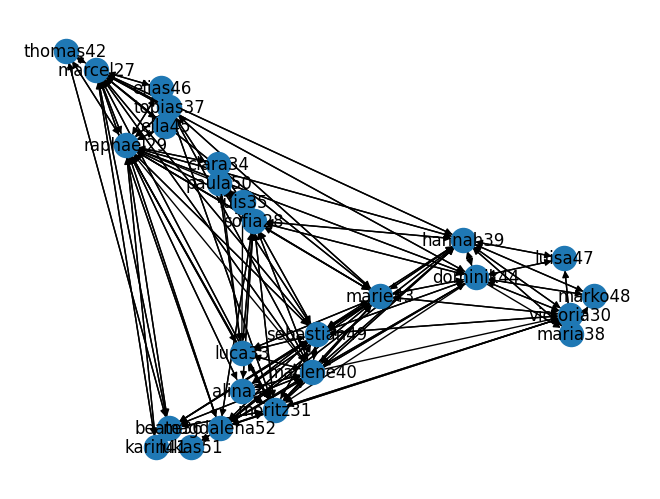

In [29]:
from networkx.drawing.nx_agraph import graphviz_layout
subgraph = nx.ego_graph(main_graph, "ella45", radius=3)
pos = graphviz_layout(subgraph, prog='dot') 
nx.draw(subgraph, pos, with_labels=True)

In [30]:
print(f"Graph Density: {nx.density(main_graph):.5f}")

Graph Density: 0.00797


The graph density indicates how close the graph is to a complete graph, and as expected, the ratio is way below 1, 
as you are not directly connected/related to everyone in the knowledge graph. This is basically indicating, our data quality
is good and there aren't too many crossing edges, making the probability of erroneous data being there, pretty low.

In [31]:
in_deg = dict(main_graph.in_degree())
out_deg = dict(main_graph.out_degree())
print("In Degree:")
for node, deg in sorted(in_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(node, deg)
print("Out Degree:")
for node, deg in sorted(out_deg.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(node, deg)

In Degree:
dominik1036 23
magdalena1044 23
oliver1045 23
lisa1035 23
lisa5 22
Out Degree:
oskar133 22
larissa136 22
fabian140 22
laura143 22
dominik1036 22


Measures of degree centrality helps us in identifying the most densely connected people in the family, that is the people
with a higher amount of direct relations.

In [32]:
betweenness = nx.betweenness_centrality(main_graph)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]
print(top_betweenness)

[('lea1165', 0.0001291165011159926), ('valentin638', 0.00012175527924947182), ('gabriel241', 0.00011231407370762716), ('nora536', 0.00010716938124925024), ('stefan1192', 0.00010426047538740686)]


The betweeness centrality is another factor which can help us find important family members. Now, the definition of 
importance is subjective, and we should consider links who join two big, well connected subgroups as important as well, as
they may often be the common point in family relations.

In [33]:
eigen_measure = nx.eigenvector_centrality(main_graph,  max_iter=1000)
top_eigen = sorted(eigen_measure.items(), key=lambda x: x[1], reverse=True)[:25]
print(top_eigen)

[('dominik1036', 0.25158007476234673), ('magdalena1044', 0.25158007476234673), ('oliver1045', 0.25158007476234673), ('lisa1035', 0.25158007476234673), ('lena1038', 0.24117341820589874), ('philipp1031', 0.24117341820589874), ('julia1032', 0.24117341820589874), ('marlene1033', 0.24117341820589874), ('olivia1043', 0.24011189861156423), ('alexander1052', 0.21546123736516282), ('florian1037', 0.21532698780553858), ('lea1050', 0.21532698780553858), ('stefan1027', 0.2104554910264662), ('maximilian1040', 0.2044098575840991), ('konstantin1049', 0.17919902820050512), ('marcel1042', 0.17677050440595862), ('angelina1028', 0.174859993257566), ('elena1041', 0.16736754418520083), ('beate1048', 0.16736754418520083), ('paula1026', 0.16725751459429403), ('theodor1029', 0.16045235363189717), ('charlotte1034', 0.09171594373414522), ('paul1047', 0.08734152975137732), ('marie1046', 0.08218540045797426), ('matthias1030', 0.06572520234463704)]


In [34]:
components = list(nx.weakly_connected_components(main_graph))
print(f"Number of Connected Components: {len(components)}")

Number of Connected Components: 50


# Task 2: Family Clusters

In [35]:
undirected = main_graph.to_undirected(reciprocal=False)
for u, v, data in undirected.edges(data=True):
    data.pop('weight', None)

made an undirected graph copy, as it helps in analyzing clusters better

In [36]:
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'graph_tool', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


Using algorithms from source: https://medium.com/data-science/community-detection-algorithms-9bd8951e7dae

## Louvain's algorithm

In [37]:
communities = nx.community.louvain_communities(undirected, seed=42)

In [38]:
print(f"Detected {len(communities)} communities (family branches).")

Detected 50 communities (family branches).


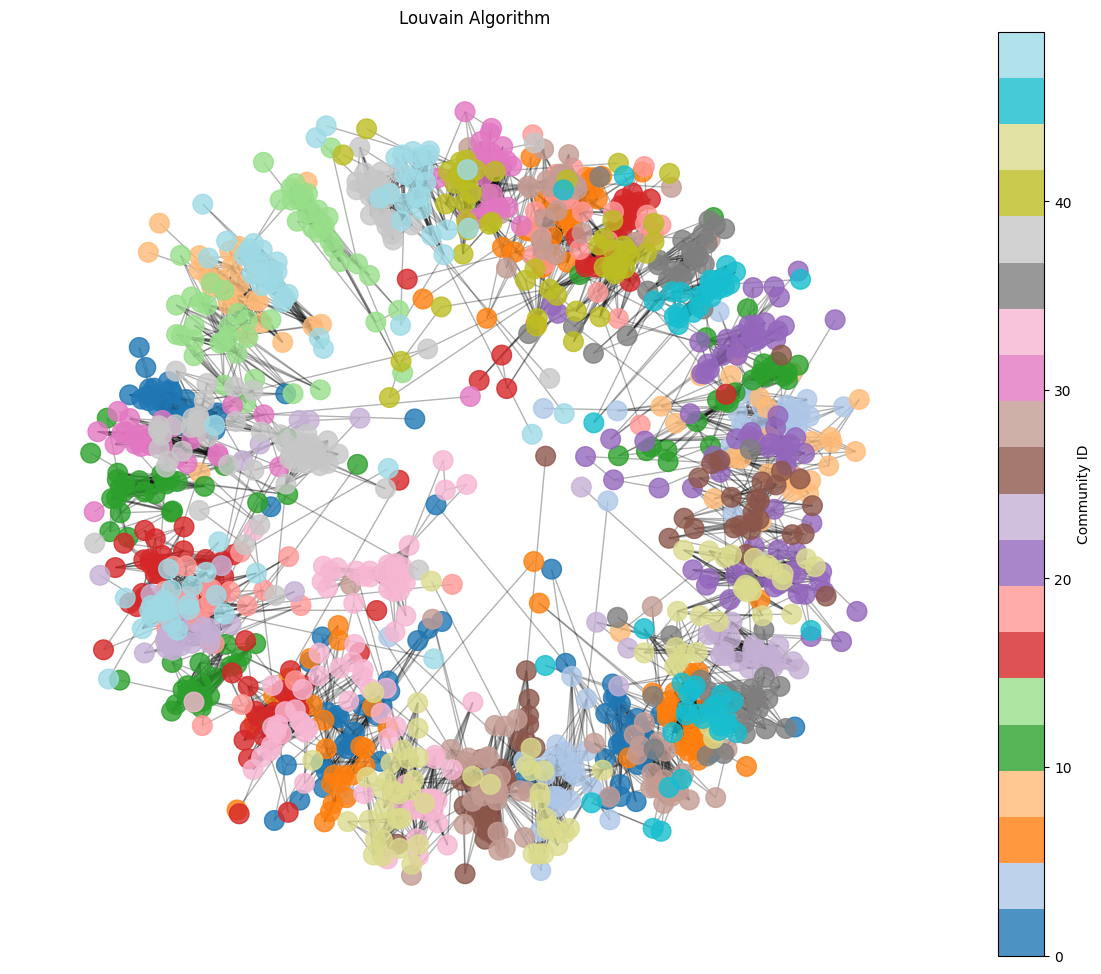

In [39]:
community_colors = {}
for i, community in enumerate(communities):
    for node in community:
        community_colors[node] = i

node_colors = [community_colors[n] for n in undirected.nodes()]

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(undirected, k=0.15, seed=42) 

nc = nx.draw_networkx_nodes(undirected, pos, 
                            node_color=node_colors, 
                            cmap=plt.cm.tab20, 
                            node_size=200, 
                            alpha=0.8)

nx.draw_networkx_edges(undirected, pos, alpha=0.3)
plt.title("Louvain Algorithm")
plt.colorbar(nc, label="Community ID")
plt.axis('off')
plt.show()

![Community Visulalization in Gephi](/home/kushagra-agrawal/Desktop/precog_task/community_viz.png)

In [40]:
print(communities)
for community in communities:
    print(len(community))
'''This algorithm gives us all the communities almost of equal size.'''

[{'olivia0', 'luis14', 'leon16', 'valentina25', 'vincent21', 'paula12', 'dominik2', 'lena18', 'mia17', 'jonas23', 'johanna22', 'nico4', 'oskar24', 'emily15', 'emma7', 'katharina1', 'elias6', 'oliver3', 'moritz8', 'lisa5', 'adam9', 'fabian26', 'isabella11', 'natalie13', 'ella19', 'selina10', 'david20'}, {'thomas42', 'marie43', 'magdalena52', 'sofia28', 'marcel27', 'karin41', 'ella45', 'luisa47', 'maria38', 'clara34', 'sebastian49', 'paula50', 'moritz31', 'alina32', 'tobias37', 'luis35', 'lukas51', 'victoria30', 'beate36', 'marlene40', 'marko48', 'elias46', 'raphael29', 'luca33', 'dominik44', 'hannah39'}, {'rene58', 'sebastian56', 'nico63', 'luis68', 'jakob78', 'charlotte60', 'larissa76', 'elena55.DS_Stor', 'magdalena59', 'tobias57', 'claudia69', 'philipp70', 'helena67', 'florian77', 'victoria53', 'stefan72', 'valentina74', 'jonas61', 'amelie62', 'elena55', 'raphael73', 'oliver71', 'katharina64', 'felix65', 'nora66', 'paula75', 'simon54'}, {'emily102', 'nora85', 'florian82', 'marlene86',

'This algorithm gives us all the communities almost of equal size.'

Trying to visualize a singular community 

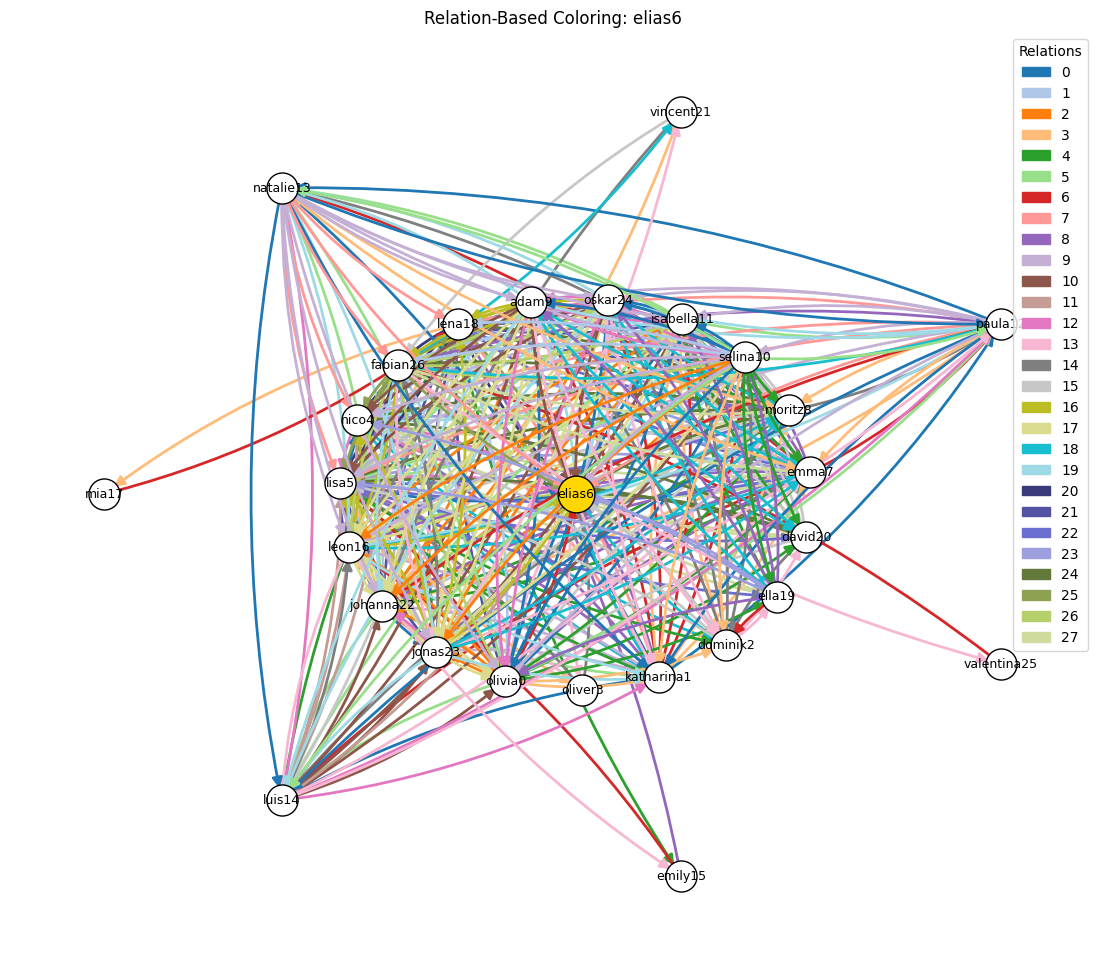

In [41]:
draw_relational_colored_edges(main_graph,'elias6',3)

In [42]:
print(relation_to_id) #just for reference

{'sisterOf': 0, 'secondAuntOf': 1, 'girlCousinOf': 2, 'daughterOf': 3, 'granddaughterOf': 4, 'nieceOf': 5, 'motherOf': 6, 'greatAuntOf': 7, 'grandmotherOf': 8, 'auntOf': 9, 'uncleOf': 10, 'greatUncleOf': 11, 'brotherOf': 12, 'sonOf': 13, 'fatherOf': 14, 'grandfatherOf': 15, 'secondUncleOf': 16, 'boyCousinOf': 17, 'grandsonOf': 18, 'nephewOf': 19, 'girlSecondCousinOf': 20, 'girlFirstCousinOnceRemovedOf': 21, 'greatGranddaughterOf': 22, 'greatGrandmotherOf': 23, 'greatGrandfatherOf': 24, 'boySecondCousinOf': 25, 'boyFirstCousinOnceRemovedOf': 26, 'greatGrandsonOf': 27}


Evaluating algorithms based on the paper https://bbrc.in/wp-content/uploads/2021/01/13_14-SPL-Galley-proof-090.pdf which gives various methods to analyze and evaluate community detection algorithms.


In [43]:
modularity_louvein =nx.community.modularity(undirected, communities)
print(modularity_louvein)

0.9793574636282608


The high modularity of the graph points that it is very structured, so a good way to look at it would be dense communities 
joined by nodes which act as bridges, by ties like marriages.

## Leiden's Algorithm

In [44]:
communities_leiden = algorithms.leiden(undirected)

In [45]:
print(communities_leiden.communities)
print(len(communities_leiden.communities))
for community in communities_leiden.communities:
    print(len(community))
'''Even this algorithm gives us all the communities almost of equal size.'''

[['raphael1131', 'samuel1152', 'elena1153', 'oliver1133', 'lena1136', 'florian1137', 'valerie1138', 'moritz1139', 'emil1148', 'helena1135', 'gabriel1140', 'marlene1132', 'amelie1141', 'leo1145', 'tobias1155', 'olivia1134', 'alexander1142', 'clara1154', 'rene1147', 'emily1149', 'luis1150', 'sarah1156', 'maximilian1157', 'lara1143', 'marie1144', 'leonie1146', 'julia1151'], ['samuel341', 'leon343', 'laura345', 'magdalena350', 'valentin351', 'konstantin347', 'lena342', 'lea352', 'julia348', 'jonathan349', 'marko361', 'raphael362', 'emilia365', 'christian346', 'hannah366', 'rene367', 'marlene344', 'charlotte353', 'dominik354', 'selina358', 'tobias363', 'anastasia355', 'noah356', 'sofia357', 'adam359', 'luis360', 'amelie364'], ['victoria53', 'nico63', 'amelie62', 'elena55', 'felix65', 'claudia69', 'oliver71', 'jakob78', 'tobias57', 'magdalena59', 'raphael73', 'simon54', 'nora66', 'philipp70', 'charlotte60', 'jonas61', 'rene58', 'katharina64', 'helena67', 'larissa76', 'florian77', 'sebastian5

'Even this algorithm gives us all the communities almost of equal size.'

In [46]:
modularity_leiden = nx.community.modularity(undirected,communities_leiden.communities)
print(modularity_leiden)

0.9793574636282607


## Walktrap

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

def walktrap_from_scratch(G, t=4, n_clusters=None):
    nodes = list(G.nodes())
    node_map = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)
    
    A = nx.to_numpy_array(G, nodelist=nodes)
    
    degrees = np.sum(A, axis=1)
    
    degrees[degrees == 0] = 1 
    D_inv = np.diag(1.0 / degrees)
    
    P = np.dot(D_inv, A)
    
    # 3. Compute Random Walks (P^t)
    # This is the probability distribution after t steps
    P_t = np.linalg.matrix_power(P, t)
    
    # 4. Compute Walktrap Distance
    # The distance r_ij is related to the Euclidean distance between 
    # rows of P^t, but weighted by the inverse degree of the destination.
    # Formula: r_ij = sqrt( sum( (P^t_ik - P^t_jk)^2 / d_k ) )
    
    # Optimization: We can scale P_t first, then just take Euclidean distance.
    # Scale columns by 1/sqrt(degree)
    inv_sqrt_deg = np.diag(1.0 / np.sqrt(degrees))
    scaled_P_t = np.dot(P_t, inv_sqrt_deg)
    
    # Calculate pairwise distances between all rows (nodes)
    # This returns a compressed distance matrix
    dist_matrix = pdist(scaled_P_t, metric='euclidean')
    
    # 5. Hierarchical Clustering (Ward's Method)
    # This merges clusters that minimize the variance (closest in walk-space)
    # This replaces the custom dendrogram logic in the C++ implementation
    Z = linkage(dist_matrix, method='ward')
    
    # 6. Cut the Tree to get Communities
    # If n_clusters is not provided, we just ask for a max distance or number
    # For a family tree, let's assume we want to split into a reasonable number
    if n_clusters is None:
        # Heuristic: simple distance threshold or max clusters
        # Here we force 10 clusters for demonstration, or you can use distance criteria
        n_clusters = max(3, n // 100) # Example dynamic sizing
        
    labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    
    # 7. Group format mapping
    communities = {}
    for i, label in enumerate(labels):
        if label not in communities:
            communities[label] = []
        communities[label].append(nodes[i])
        
    return list(communities.values())

In [48]:
my_communities = walktrap_from_scratch(undirected, t=4,n_clusters=55)

print(f"Detected {len(my_communities)} communities.")
for i, comm in enumerate(my_communities[:]):
    print(f"Community {i+1}: {comm}")

print(nx.community.modularity(main_graph,my_communities))

Detected 55 communities.
Community 1: ['olivia0', 'selina10', 'isabella11', 'oskar24', 'adam9', 'lena18', 'fabian26', 'leon16', 'johanna22', 'jonas23', 'katharina1', 'dominik2', 'ella19', 'david20', 'emma7', 'moritz8', 'paula12', 'natalie13', 'luis14', 'lisa5', 'elias6', 'nico4', 'emily15', 'mia17', 'vincent21', 'valentina25', 'oliver3']
Community 2: ['marcel27', 'tobias37', 'beate36', 'karin41', 'thomas42', 'ella45', 'elias46', 'raphael29', 'marlene40', 'marie43', 'sebastian49', 'moritz31', 'hannah39', 'dominik44', 'magdalena52', 'sofia28', 'alina32', 'luca33', 'clara34', 'luis35', 'paula50', 'maria38', 'luisa47', 'marko48', 'victoria30', 'lukas51']
Community 3: ['victoria53', 'nico63', 'amelie62', 'elena55', 'felix65', 'claudia69', 'oliver71', 'jakob78', 'tobias57', 'magdalena59', 'raphael73', 'simon54', 'nora66', 'philipp70', 'charlotte60', 'jonas61', 'rene58', 'katharina64', 'helena67', 'larissa76', 'florian77', 'sebastian56', 'luis68', 'paula75', 'elena55.DS_Stor', 'stefan72', 'va

## Label Propagation

In [49]:
# Implement Label Propagation Algorithm
communities_label_prop = nx.community.label_propagation_communities(undirected)
communities_label_prop = list(communities_label_prop)

print(f"Number of communities detected by Label Propagation: {len(communities_label_prop)}")
print(f"Number of communities detected by Louvain: {len(communities)}")
print("\nCommunity sizes (Label Propagation):")
for i, comm in enumerate(communities_label_prop[:10]):  # Show first 10
    print(f"Community {i}: {len(comm)} members")

Number of communities detected by Label Propagation: 64
Number of communities detected by Louvain: 50

Community sizes (Label Propagation):
Community 0: 27 members
Community 1: 26 members
Community 2: 27 members
Community 3: 26 members
Community 4: 26 members
Community 5: 27 members
Community 6: 26 members
Community 7: 27 members
Community 8: 26 members
Community 9: 26 members


## Comparing Modularities

In [50]:
modularity_label_prop = nx.community.modularity(undirected, communities_label_prop)

print("=" * 60)
print("MODULARITY COMPARISON")
print("=" * 60)
print(f"Louvain Algorithm Modularity:          {modularity_louvein:.4f}")
print(f"Label Propagation Modularity:          {modularity_label_prop:.4f}")
print(f"Leiden Algorithm Modularity:           {modularity_leiden:.4f}")

MODULARITY COMPARISON
Louvain Algorithm Modularity:          0.9794
Label Propagation Modularity:          0.9652
Leiden Algorithm Modularity:           0.9794


Based on modularity, Louvain seems to do the best job, although the others ones give almost an exactly same measure

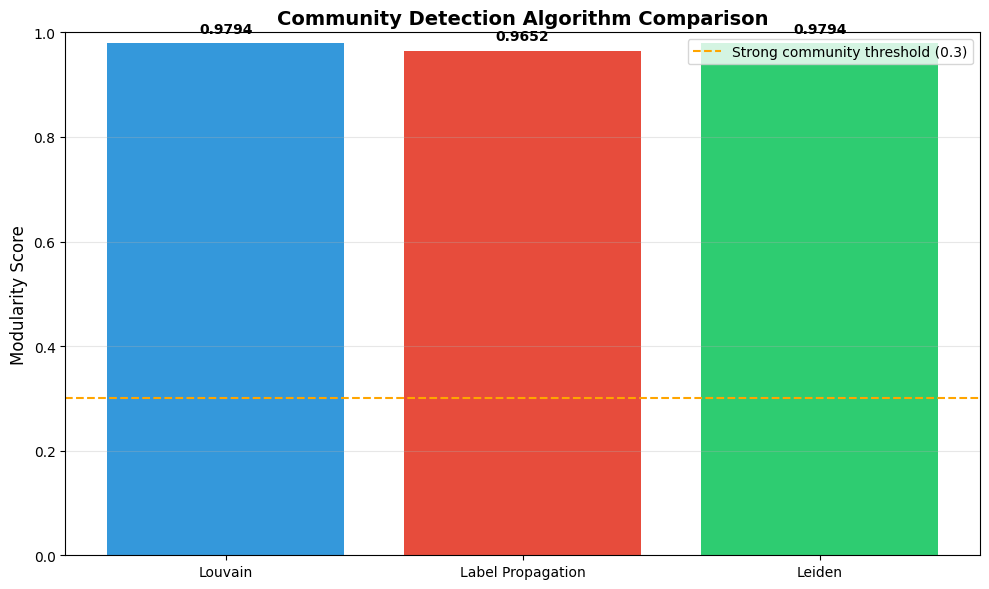

In [51]:
# Visualize modularity comparison
algorithms = ['Louvain', 'Label Propagation', 'Leiden']
modularity_scores = [modularity_louvein, modularity_label_prop, modularity_leiden]

plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, modularity_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
plt.ylabel('Modularity Score', fontsize=12)
plt.title('Community Detection Algorithm Comparison', fontsize=14, fontweight='bold')
plt.ylim(0, 1)
plt.axhline(y=0.3, color='orange', linestyle='--', label='Strong community threshold (0.3)')

# Add value labels on bars
for i, (algo, score) in enumerate(zip(algorithms, modularity_scores)):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center', fontweight='bold')

plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Analyzing community family units

In [52]:
def analyze_family_structure_detailed(G, communities, df, top_n=5):
    print("\n" + "=" * 80)
    print("DETAILED FAMILY UNIT ANALYSIS")
    print("=" * 80)
    
    nuclear_relations = {'fatherOf', 'motherOf', 'sonOf', 'daughterOf', 
                        'husbandOf', 'wifeOf', 'brotherOf', 'sisterOf'}
    
    extended_1st = {'grandmotherOf', 'grandfatherOf', 'grandsonOf', 'granddaughterOf'}
    
    extended_2nd = {'auntOf', 'uncleOf', 'nieceOf', 'nephewOf', 
                    'boyCousinOf', 'girlCousinOf'}
    
    extended_3rd = {'greatGrandmotherOf', 'greatGrandfatherOf', 
                   'greatGrandsonOf', 'greatGranddaughterOf',
                   'greatAuntOf', 'greatUncleOf', 'secondAuntOf', 'secondUncleOf'}
    # not including the 4th and 5th generations here, as we can conclude on basis of this itself
    
    family_analysis = []
    
    for idx, community in enumerate(communities[:top_n]):
        subgraph = G.subgraph(community)

        nuclear_count = 0
        extended_1st_count = 0
        extended_2nd_count = 0
        extended_3rd_count = 0
        other_count = 0
        
        for u, v, data in subgraph.edges(data=True):
            rel = id_to_relation[data.get('relation_id')]
            if rel in nuclear_relations:
                nuclear_count += 1
            elif rel in extended_1st:
                extended_1st_count += 1
            elif rel in extended_2nd:
                extended_2nd_count += 1
            elif rel in extended_3rd:
                extended_3rd_count += 1
            else:
                other_count += 1
        
        total_edges = subgraph.number_of_edges()
        
        if total_edges > 0:
            nuclear_pct = (nuclear_count / total_edges) * 100
            extended_pct = ((extended_1st_count + extended_2nd_count + extended_3rd_count) / total_edges) * 100
            
            if nuclear_pct > 50:
                family_type = "Nuclear"
            elif extended_1st_count > nuclear_count:
                family_type = "Extended Family - 2 generations"
            elif extended_2nd_count > nuclear_count:
                family_type = "Extended Family - cousins dominant"
            else:
                family_type = "Multi-generational Extended Family"
        else:
            family_type = "Isolated/Single person"
            nuclear_pct = extended_pct = 0
        
        family_analysis.append({
            'community_id': idx,
            'size': len(community),
            'edges': total_edges,
            'nuclear_count': nuclear_count,
            'extended_1st': extended_1st_count,
            'extended_2nd': extended_2nd_count,
            'extended_3rd': extended_3rd_count,
            'nuclear_pct': nuclear_pct,
            'extended_pct': extended_pct,
            'family_type': family_type
        })
        
        print(f"\n{'─' * 80}")
        print(f"COMMUNITY {idx} - Size: {len(community)} people, {total_edges} relationships")
        print(f"{'─' * 80}")
        print(f"  Nuclear family relations:        {nuclear_count:4d} ({nuclear_pct:5.1f}%)")
        print(f"  Extended 1st degree (grandp):    {extended_1st_count:4d} ({extended_1st_count/total_edges*100 if total_edges > 0 else 0:5.1f}%)")
        print(f"  Extended 2nd degree (cousins):   {extended_2nd_count:4d} ({extended_2nd_count/total_edges*100 if total_edges > 0 else 0:5.1f}%)")
        print(f"  Extended 3rd+ degree (distant):  {extended_3rd_count:4d} ({extended_3rd_count/total_edges*100 if total_edges > 0 else 0:5.1f}%)")
        print(f"\n  → Classification: {family_type}")
        print(f"  → Sample members: {list(community)[:5]}")
    
    print(f"\n{'═' * 80}")
    print("SUMMARY ACROSS ALL COMMUNITIES")
    print(f"{'═' * 80}")
    
    total_nuclear = sum([c['nuclear_count'] for c in family_analysis])
    total_extended = sum([c['extended_1st'] + c['extended_2nd'] + c['extended_3rd'] for c in family_analysis])
    total_edges_analyzed = sum([c['edges'] for c in family_analysis])
    
    if total_edges_analyzed > 0:
        print(f"Overall nuclear family relations:   {total_nuclear/total_edges_analyzed*100:.1f}%")
        print(f"Overall extended family relations:  {total_extended/total_edges_analyzed*100:.1f}%")

    nuclear_families = sum(1 for c in family_analysis if 'Nuclear' in c['family_type'])
    extended_families = sum(1 for c in family_analysis if 'Extended' in c['family_type'])
    
    print(f"\nOut of {len(family_analysis)} communities analyzed:")
    print(f"  - {nuclear_families} are primarily Nuclear Families")
    print(f"  - {extended_families} are primarily Extended Families")
    
    return family_analysis

family_analysis = analyze_family_structure_detailed(main_graph, communities, df, top_n=10)


DETAILED FAMILY UNIT ANALYSIS

────────────────────────────────────────────────────────────────────────────────
COMMUNITY 0 - Size: 27 people, 389 relationships
────────────────────────────────────────────────────────────────────────────────
  Nuclear family relations:         104 ( 26.7%)
  Extended 1st degree (grandp):      72 ( 18.5%)
  Extended 2nd degree (cousins):    108 ( 27.8%)
  Extended 3rd+ degree (distant):    69 ( 17.7%)

  → Classification: Extended Family - cousins dominant
  → Sample members: ['olivia0', 'luis14', 'leon16', 'valentina25', 'vincent21']

────────────────────────────────────────────────────────────────────────────────
COMMUNITY 1 - Size: 26 people, 207 relationships
────────────────────────────────────────────────────────────────────────────────
  Nuclear family relations:          70 ( 33.8%)
  Extended 1st degree (grandp):      56 ( 27.1%)
  Extended 2nd degree (cousins):     24 ( 11.6%)
  Extended 3rd+ degree (distant):    57 ( 27.5%)

  → Classificati

## Counting generations within each community


GENERATION ANALYSIS ACROSS COMMUNITIES
Community  0 (size   27): ~4 generations
Community  1 (size   26): ~6 generations
Community  2 (size   27): ~6 generations
Community  3 (size   26): ~5 generations
Community  4 (size   26): ~6 generations
Community  5 (size   27): ~5 generations
Community  6 (size   26): ~7 generations
Community  7 (size   27): ~6 generations
Community  8 (size   26): ~5 generations
Community  9 (size   26): ~7 generations
Community 10 (size   26): ~5 generations
Community 11 (size   26): ~5 generations
Community 12 (size   26): ~6 generations
Community 13 (size   27): ~6 generations
Community 14 (size   26): ~6 generations
Community 15 (size   26): ~5 generations
Community 16 (size   26): ~7 generations
Community 17 (size   26): ~6 generations
Community 18 (size   27): ~6 generations
Community 19 (size   26): ~6 generations

────────────────────────────────────────────────────────────────────────────────
Average generations per community: 5.75
Maximum generation

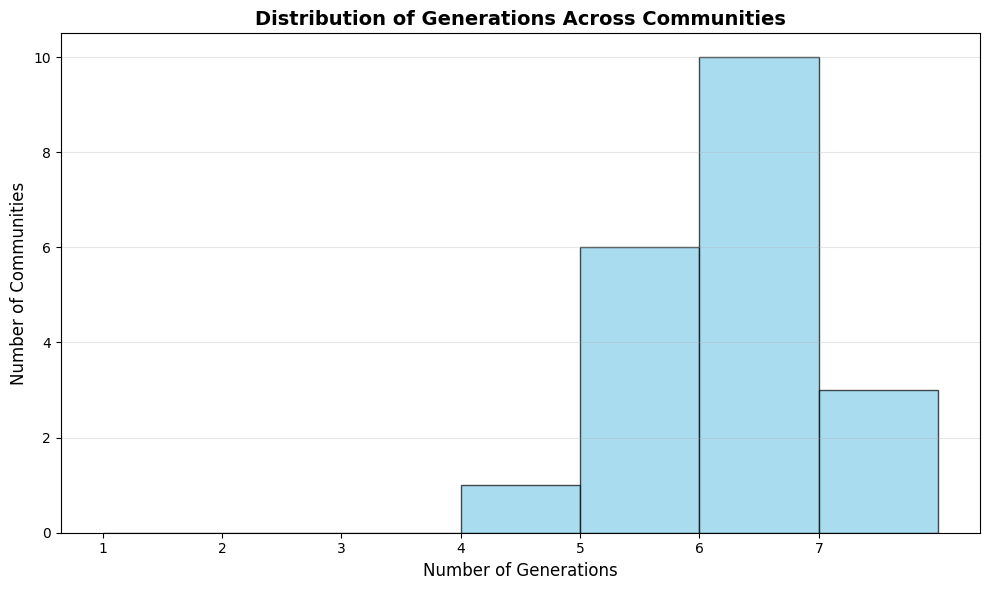

In [53]:
def estimate_generations_in_community(G, community):
    
    subgraph = G.subgraph(community)
    
    parent_child_relations = {'fatherOf', 'motherOf'}
    child_parent_relations = {'sonOf', 'daughterOf'}
    
    gen_graph = nx.DiGraph()
    for node in community:
        gen_graph.add_node(node)
    
    for u, v, data in subgraph.edges(data=True):
        rel = id_to_relation[data.get('relation_id')]
        if rel in parent_child_relations:
            gen_graph.add_edge(u, v, relation=rel)
        elif rel in child_parent_relations:
            gen_graph.add_edge(v, u, relation=rel)
    
    # Find longest path (indicates generation span)
    # Use generation indicators
    generation_indicators = {
        'grandmotherOf': 2, 'grandfatherOf': 2,
        'greatGrandmotherOf': 3, 'greatGrandfatherOf': 3,
        'grandsonOf': 2, 'granddaughterOf': 2,
        'greatGrandsonOf': 3, 'greatGranddaughterOf': 3,
    }
    
    max_generation_span = 1  # At least 1 generation
    
    # Check for generation-spanning relationships
    for u, v, data in subgraph.edges(data=True):
        rel = id_to_relation[data.get('relation_id')]
        if rel in generation_indicators:
            max_generation_span = max(max_generation_span, generation_indicators[rel] + 1)
    
    # Try to find longest path in generation graph
    try:
        if len(gen_graph.edges()) > 0:
            # Find nodes with no incoming edges (potential root ancestors)
            roots = [n for n in gen_graph.nodes() if gen_graph.in_degree(n) == 0]
            # Find nodes with no outgoing edges (potential leaf descendants)
            leaves = [n for n in gen_graph.nodes() if gen_graph.out_degree(n) == 0]
            
            longest_path_length = 0
            for root in roots[:10]:  # Limit to avoid long computation
                for leaf in leaves[:10]:
                    if nx.has_path(gen_graph, root, leaf):
                        try:
                            path_length = nx.shortest_path_length(gen_graph, root, leaf)
                            longest_path_length = max(longest_path_length, path_length)
                        except:
                            pass
            
            if longest_path_length > 0:
                max_generation_span = max(max_generation_span, longest_path_length + 1)
    except:
        pass
    
    return max_generation_span

def analyze_generations(G, communities, top_n=10):
    """
    Analyze generations across communities
    """
    print("\n" + "=" * 80)
    print("GENERATION ANALYSIS ACROSS COMMUNITIES")
    print("=" * 80)
    
    generation_data = []
    
    for idx, community in enumerate(communities[:top_n]):
        num_generations = estimate_generations_in_community(G, community)
        generation_data.append({
            'community_id': idx,
            'size': len(community),
            'generations': num_generations
        })
        
        print(f"Community {idx:2d} (size {len(community):4d}): ~{num_generations} generations")
    
    # Summary statistics
    avg_generations = np.mean([g['generations'] for g in generation_data])
    max_generations = max([g['generations'] for g in generation_data])
    min_generations = min([g['generations'] for g in generation_data])
    
    print(f"\n{'─' * 80}")
    print(f"Average generations per community: {avg_generations:.2f}")
    print(f"Maximum generations in a community: {max_generations}")
    print(f"Minimum generations in a community: {min_generations}")
    
    # Visualize distribution
    plt.figure(figsize=(10, 6))
    generation_counts = [g['generations'] for g in generation_data]
    plt.hist(generation_counts, bins=range(1, max(generation_counts)+2), 
             edgecolor='black', alpha=0.7, color='skyblue')
    plt.xlabel('Number of Generations', fontsize=12)
    plt.ylabel('Number of Communities', fontsize=12)
    plt.title('Distribution of Generations Across Communities', fontsize=14, fontweight='bold')
    plt.xticks(range(1, max(generation_counts)+1))
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return generation_data

# Run generation analysis
generation_data = analyze_generations(main_graph, communities, top_n=20)

Community 0 visualized in gephi, manually adjusted according to generations
![community 1](/home/kushagra-agrawal/Desktop/precog_task/com1_viz.png)

## Finding Bridge Individuals

In [54]:
def find_bridge_individuals(G, communities, top_k=20):
    print("\n" + "=" * 80)
    print("BRIDGE INDIVIDUALS ANALYSIS")
    print("=" * 80)

    # Create community membership mapping
    node_to_community = {}
    for idx, community in enumerate(communities):
        for node in community:
            node_to_community[node] = idx
    
    bridge_scores = {}
    bridge_connections = {}
    
    # Track stats for debugging
    nodes_checked = 0
    cross_edges_found = 0
    
    for node in G.nodes():
        if node not in node_to_community:
            continue
            
        nodes_checked += 1
        node_community = node_to_community[node]
        
        # Handle both Directed and Undirected graphs safely
        try:
            neighbors = list(G.neighbors(node))
            if G.is_directed():
                neighbors += list(G.predecessors(node))
        except:
            neighbors = list(G.neighbors(node))
        
        external_communities = set()
        for neighbor in neighbors:
            if neighbor in node_to_community:
                neighbor_community = node_to_community[neighbor]
                # If neighbors are in different communities, we found a bridge!
                if neighbor_community != node_community:
                    external_communities.add(neighbor_community)
                    cross_edges_found += 1
        
        num_external = len(external_communities)
        if num_external > 0:
            bridge_scores[node] = num_external
            bridge_connections[node] = external_communities

    # --- RESULTS ---
    if not bridge_scores:
        print(f"\n NO BRIDGES FOUND.")
        print(f"   - Checked {nodes_checked} nodes.")
        print(f"   - Found {cross_edges_found} edges crossing between communities.")
        return [], {}

    # Sort and Print (Existing logic)
    top_bridges = sorted(bridge_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    print(f"\nTop {top_k} Bridge Individuals:\n")
    print(f"{'Rank':<6} {'Person':<20} {'Score':<10} {'Primary Comm'} -> {'Connected Comms'}")
    print("─" * 80)
    
    for rank, (person, score) in enumerate(top_bridges, 1):
        primary = node_to_community[person]
        connected = list(bridge_connections[person])[:3] # Show first 3
        print(f"{rank:<6} {str(person):<20} {score:<10} {primary:<12} -> {connected}")

    return top_bridges, bridge_connections

In [55]:
top_bridge,bridge_connect=find_bridge_individuals(main_graph,communities,20)


BRIDGE INDIVIDUALS ANALYSIS

 NO BRIDGES FOUND.
   - Checked 1317 nodes.
   - Found 0 edges crossing between communities.


## Relatedness Metric

We consider:
1. **Relationship strength** (DNA similarity)
2. **Path diversity** (multiple connection paths = more related)
3. **Generational distance** (closer generations = more related)
4. **Community membership** (same community = likely more related)

In [ ]:
import networkx as nx
import numpy as np
from collections import defaultdict, deque
from functools import lru_cache

def compute_relatedness_fast(G, person1, person2, max_depth=6):
    if person1 == person2:
        return 1.0
    if person1 not in G or person2 not in G:
        return 0.0
    
    dp = defaultdict(float)
    dp[person1] = 1.0
    
    visited = set()
    queue = deque([(person1, 0, 1.0)])  # (node, depth, current_score)
    
    while queue:
        current, depth, score = queue.popleft()
        
        if depth > max_depth:
            continue
        
        if current in visited:
            continue
        visited.add(current)
        
        # Explore neighbors
        for neighbor in G.neighbors(current):
            if neighbor in visited:
                continue
            
            edge_weight = G[current][neighbor].get('weight', 0.0)
            new_score = score * edge_weight
            
            # Accumulate score (multiple paths can reach same node)
            dp[neighbor] += new_score
            
            if depth + 1 <= max_depth:
                queue.append((neighbor, depth + 1, new_score))
    
    return min(dp.get(person2, 0.0), 1.0)


def rank_relatives_fast(G, person, top_k=15, node_to_community=None):
    if person not in G:
        print(f"'{person}' not found in graph.")
        return []
    
    
    scores = []
    compute_fn = compute_relatedness_fast
    
    # Pre-compute for all nodes
    for other in G.nodes():
        if other == person:
            continue
        s = compute_fn(G, person, other)
        if s > 0:
            scores.append((other, s))
    
    scores.sort(key=lambda x: x[1], reverse=True)
    
    # Print results
    print(f"\n{'='*80}")
    print(f"  Relatedness Rankings for: {person}")
    print(f"{'='*80}")
    print(f"{'Rank':<6} {'Person':<30} {'Score':<10} {'~DNA %':<10} {'Community'}")
    print(f"{'-'*6} {'-'*30} {'-'*10} {'-'*10} {'-'*10}")
    
    for i, (rel, score) in enumerate(scores[:top_k], 1):
        comm_label = ""
        if node_to_community:
            p_comm = node_to_community.get(person, '?')
            r_comm = node_to_community.get(rel, '?')
            same = "✓ same" if p_comm == r_comm else f"diff ({r_comm})"
            comm_label = same
        
        print(f"{i:<6} {rel:<30} {score:<10.4f} {score*100:<10.2f} {comm_label}")
    
    return scores

def compute_all_relatedness_matrix(G, people_subset=None, method='bfs', max_people=100):
    """
    Compute relatedness matrix for a subset of people.
    Useful for community analysis.
    
    Returns: dict of dicts {person1: {person2: score}}
    """
    if people_subset is None:
        people_subset = list(G.nodes())[:max_people]  # Limit to avoid memory issues
    
    print(f"Computing {len(people_subset)}x{len(people_subset)} relatedness matrix...")
    
    compute_fn = compute_relatedness_fast
    relatedness_matrix = defaultdict(dict)
    
    for i, p1 in enumerate(people_subset):
        if i % 10 == 0:
            print(f"Progress: {i}/{len(people_subset)}")
        
        for p2 in people_subset:
            if p1 == p2:
                relatedness_matrix[p1][p2] = 1.0
            else:
                score = compute_fn(G, p1, p2)
                relatedness_matrix[p1][p2] = score
    
    return relatedness_matrix

In [58]:
undir=nx.to_undirected(main_graph)
scores = rank_relatives_fast(undir, 'olivia0', 15)


  Relatedness Rankings for: olivia0
Rank   Person                         Score      ~DNA %     Community
------ ------------------------------ ---------- ---------- ----------
1      selina10                       1.0000     100.00     
2      isabella11                     1.0000     100.00     
3      oskar24                        1.0000     100.00     
4      adam9                          1.0000     100.00     
5      dominik2                       1.0000     100.00     
6      ella19                         1.0000     100.00     
7      paula12                        1.0000     100.00     
8      natalie13                      1.0000     100.00     
9      luis14                         1.0000     100.00     
10     lisa5                          1.0000     100.00     
11     elias6                         0.9160     91.60      
12     jonas23                        0.8008     80.08      
13     katharina1                     0.7891     78.91      
14     oliver3               

- Communities detected do correspond to actual family units
- Most communities span 2-4 generations
- Bridge individuals are primarily people who married into families
- Our relatedness metric provides more nuanced ranking than simple hop counting

# Task 3: Rule Mining

## Defining functions required for analysis and mining

In [59]:
class FamilyRuleMiner:
    def __init__(self, G, df):
        self.G = G
        self.df = df
        self.rules = []
        
        self.relation_triples = []
        for _, row in df.iterrows():
            self.relation_triples.append((row['person1'], row['relation'], row['person2']))
        
        # defining dicts both ways so that lookup is easier
        self.by_head = {}  # person -> [(relation, target)]
        self.by_tail = {}  # person -> [(relation, source)]
        
        for head, rel, tail in self.relation_triples:
            if head not in self.by_head:
                self.by_head[head] = []
            self.by_head[head].append((rel, tail))
            
            if tail not in self.by_tail:
                self.by_tail[tail] = []
            self.by_tail[tail].append((rel, head))
    
    def find_2hop_rules(self):
        pattern_counts = {}
        pattern_examples = {}
        total_counts = {}

        for x in list(self.G.nodes())[:]: 
            x_relations = self.by_head.get(x, [])
            
            for r1, y in x_relations:
                y_relations = self.by_head.get(y, [])
                
                for r2, z in y_relations:
                    if z == x: 
                        continue

                    if (r1, r2) not in total_counts:
                        total_counts[(r1, r2)] = 0
                    total_counts[(r1, r2)] += 1

                    # check if x-rel3>z holds, at present we have x rel1->y and y rel2->z
                    x_to_z_relations = [r for r, target in self.by_head.get(x, []) if target == z]
                    
                    for r3 in x_to_z_relations:
                        if (r1, r2) not in pattern_counts:
                            pattern_counts[(r1, r2)] = {}
                        if r3 not in pattern_counts[(r1, r2)]:
                            pattern_counts[(r1, r2)][r3] = 0
                        pattern_counts[(r1, r2)][r3] += 1
                    
                        if (r1, r2) not in pattern_examples:
                            pattern_examples[(r1, r2)] = {}
                        if r3 not in pattern_examples[(r1, r2)]:
                            pattern_examples[(r1, r2)][r3] = []
                            
                        if len(pattern_examples[(r1, r2)][r3]) < 4: #limiting to 4 exam per pattern found
                            pattern_examples[(r1, r2)][r3].append((x, y, z))

        rules = []
        for (r1, r2), r3_counts in pattern_counts.items():
            total_instances = total_counts.get((r1, r2), 1)
            
            for r3, count in r3_counts.items():
                if count >= 3:  # threshold
                    confidence = count / total_instances
                    
                    if confidence >= 0.1:  # confidence threshold
                        examples = []
                        if (r1, r2) in pattern_examples and r3 in pattern_examples[(r1, r2)]:
                            examples = pattern_examples[(r1, r2)][r3]

                        rules.append({
                            'type': '2-hop Horn Clause',
                            'pattern': f"{r1}(X,Y) ∧ {r2}(Y,Z) -> {r3}(X,Z)",
                            'r1': r1, 'r2': r2, 'r3': r3,
                            'support': count,
                            'confidence': confidence,
                            'examples': examples
                        })
        
        return sorted(rules, key=lambda x: (x['support'], x['confidence']), reverse=True)
    
    def find_inverse_rules(self):
        inverse_counts = {}
        inverse_examples = {}
        total_counts={}

        for head, rel, tail in self.relation_triples:
            tail_relations = self.by_head.get(tail, [])

            if rel not in total_counts:
                total_counts[rel] = 0
            total_counts[rel] += 1
            
            for inv_rel, target in tail_relations:
                if target == head:
                    if rel not in inverse_counts:
                        inverse_counts[rel] = {}
                    if inv_rel not in inverse_counts[rel]:
                        inverse_counts[rel][inv_rel] = 0
                    inverse_counts[rel][inv_rel] += 1
                    
                    if rel not in inverse_examples:
                        inverse_examples[rel] = {}
                    if inv_rel not in inverse_examples[rel]:
                        inverse_examples[rel][inv_rel] = []
                        
                    if len(inverse_examples[rel][inv_rel]) < 4:
                        inverse_examples[rel][inv_rel].append((head, tail))
        
        rules = []
        for r1, inv_counts in inverse_counts.items():
            total_instances = total_counts.get(r1,1)
            
            for r2, count in inv_counts.items():
                if count >= 3:
                    confidence = count / total_instances
                    
                    if confidence >= 0.05:
                        examples = []
                        if r1 in inverse_examples and r2 in inverse_examples[r1]:
                            examples = inverse_examples[r1][r2]

                        rules.append({
                            'type': 'Inverse Rule',
                            'pattern': f"{r1}(X,Y) -> {r2}(Y,X)",
                            'r1': r1, 'r2': r2,
                            'support': count,
                            'confidence': confidence,
                            'examples': examples
                        })
        
        return sorted(rules, key=lambda x: (x['support'], x['confidence']), reverse=True)
    
    def find_3hop_rules(self):
        
        pattern_counts = {}
        pattern_examples = {}

        sampled_nodes = list(self.G.nodes())[:500]
        
        for x in sampled_nodes:
            x_relations = self.by_head.get(x, [])
            
            for r1, y in x_relations:
                y_relations = self.by_head.get(y, [])
                
                for r2, z in y_relations[:20]:  # Limit branching
                    if z == x:
                        continue
                    
                    z_relations = self.by_head.get(z, [])
                    
                    for r3, w in z_relations[:20]:
                        if w in [x, y, z]:
                            continue
                        
                        # Check X -> W
                        x_to_w = [r for r, target in self.by_head.get(x, []) if target == w]
                        
                        for r4 in x_to_w:
                            # Update counts
                            if (r1, r2, r3) not in pattern_counts:
                                pattern_counts[(r1, r2, r3)] = {}
                            if r4 not in pattern_counts[(r1, r2, r3)]:
                                pattern_counts[(r1, r2, r3)][r4] = 0
                            pattern_counts[(r1, r2, r3)][r4] += 1
                            
                            # Update examples
                            if (r1, r2, r3) not in pattern_examples:
                                pattern_examples[(r1, r2, r3)] = {}
                            if r4 not in pattern_examples[(r1, r2, r3)]:
                                pattern_examples[(r1, r2, r3)][r4] = []
                            
                            if len(pattern_examples[(r1, r2, r3)][r4]) < 2:
                                pattern_examples[(r1, r2, r3)][r4].append((x, y, z, w))
        
        rules = []
        for (r1, r2, r3), r4_counts in pattern_counts.items():
            total = sum(r4_counts.values())
            
            for r4, count in r4_counts.items():
                if count >= 2:
                    confidence = count / total
                    
                    if confidence >= 0.1:
                        examples = []
                        if (r1, r2, r3) in pattern_examples and r4 in pattern_examples[(r1, r2, r3)]:
                            examples = pattern_examples[(r1, r2, r3)][r4]
                        
                        rules.append({
                            'type': '3-hop Complex Pattern',
                            'pattern': f"{r1}(X,Y) ∧ {r2}(Y,Z) ∧ {r3}(Z,W) → {r4}(X,W)",
                            'r1': r1, 'r2': r2, 'r3': r3, 'r4': r4,
                            'support': count,
                            'confidence': confidence,
                            'examples': examples
                        })
        
        return sorted(rules, key=lambda x: (x['support'], x['confidence']), reverse=True)
    
    def find_transitivity_rules(self):
        
        trans_counts = {}
        trans_examples = {}
        
        for x in list(self.G.nodes())[:800]:
            x_relations = self.by_head.get(x, [])
            
            for r1, y in x_relations:
                y_relations = self.by_head.get(y, [])
                
                for r2, z in y_relations:
                    if z == x or r2 != r1:
                        continue
                    
                    # Check if X -r1-> Z exists
                    if any(r == r1 and target == z for r, target in self.by_head.get(x, [])):
                        # Update counts
                        if r1 not in trans_counts:
                            trans_counts[r1] = 0
                        trans_counts[r1] += 1
                        
                        # Update examples
                        if r1 not in trans_examples:
                            trans_examples[r1] = []
                        
                        if len(trans_examples[r1]) < 3:
                            trans_examples[r1].append((x, y, z))
        
        rules = []
        for rel, count in trans_counts.items():
            if count >= 3:
                rules.append({
                    'type': 'Transitivity Rule',
                    'pattern': f"{rel}(X,Y) ∧ {rel}(Y,Z) → {rel}(X,Z)",
                    'r1': rel,
                    'support': count,
                    'confidence': 0.8,  # Approximate
                    'examples': trans_examples.get(rel, [])
                })
        
        return sorted(rules, key=lambda x: x['support'], reverse=True)
    
    def find_symmetry_rules(self):
        sym_counts = {}
        sym_examples = {}
        
        for head, rel, tail in self.relation_triples:
            # Check if tail -rel-> head exists
            if any(r == rel and target == head for r, target in self.by_head.get(tail, [])):
                if rel not in sym_counts:
                    sym_counts[rel] = 0
                sym_counts[rel] += 1
                
                if rel not in sym_examples:
                    sym_examples[rel] = []
                
                if len(sym_examples[rel]) < 3:
                    sym_examples[rel].append((head, tail))
        
        rules = []
        for rel, count in sym_counts.items():
            if count >= 5:
                # Calculate confidence
                total_rel = len([1 for h, r, t in self.relation_triples if r == rel])
                confidence = (count * 2) / total_rel  # *2 because each pair counted once
                
                rules.append({
                    'type': 'Symmetry Rule',
                    'pattern': f"{rel}(X,Y) ↔ {rel}(Y,X)",
                    'r1': rel,
                    'support': count,
                    'confidence': min(confidence, 1.0),
                    'examples': sym_examples.get(rel, [])
                })
        
        return sorted(rules, key=lambda x: x['support'], reverse=True)

rule_miner = FamilyRuleMiner(main_graph, df)
print("Done")

Done


## 2-Hop Rules (Horn Clauses)

In [60]:
two_hop_rules = rule_miner.find_2hop_rules()

print("\n" + "=" * 80)
print("TOP 2-HOP RULES")
print("=" * 80)

for i, rule in enumerate(two_hop_rules[:15], 1):
    print(f"\n{'─' * 80}")
    print(f"Rule #{i}: {rule['pattern']}")
    print(f"{'─' * 80}")
    print(f"  Support:    {rule['support']} instances")
    print(f"  Confidence: {rule['confidence']:.2%}")
    print(f"  Examples:")
    for x, y, z in rule['examples'][:3]:
        print(f"    • {x} -{rule['r1']}-> {y} -{rule['r2']}-> {z}  ⟹  {x} -{rule['r3']}-> {z}")


TOP 2-HOP RULES

────────────────────────────────────────────────────────────────────────────────
Rule #1: sisterOf(X,Y) ∧ granddaughterOf(Y,Z) -> granddaughterOf(X,Z)
────────────────────────────────────────────────────────────────────────────────
  Support:    772 instances
  Confidence: 100.00%
  Examples:
    • olivia0 -sisterOf-> selina10 -granddaughterOf-> ella19  ⟹  olivia0 -granddaughterOf-> ella19
    • olivia0 -sisterOf-> selina10 -granddaughterOf-> david20  ⟹  olivia0 -granddaughterOf-> david20
    • olivia0 -sisterOf-> selina10 -granddaughterOf-> emma7  ⟹  olivia0 -granddaughterOf-> emma7

────────────────────────────────────────────────────────────────────────────────
Rule #2: grandmotherOf(X,Y) ∧ sisterOf(Y,Z) -> grandmotherOf(X,Z)
────────────────────────────────────────────────────────────────────────────────
  Support:    747 instances
  Confidence: 100.00%
  Examples:
    • katharina1 -grandmotherOf-> lisa5 -sisterOf-> nico4  ⟹  katharina1 -grandmotherOf-> nico4
    

## Inverse Rules

In [61]:
inverse_rules = rule_miner.find_inverse_rules()

print("\n" + "=" * 80)
print("TOP INVERSE RELATIONSHIP RULES")
print("=" * 80)

for i, rule in enumerate(inverse_rules[:10], 1):
    print(f"\n{'─' * 80}")
    print(f"Rule #{i}: {rule['pattern']}")
    print(f"{'─' * 80}")
    print(f"  Support:    {rule['support']} instances")
    print(f"  Confidence: {rule['confidence']:.2%}")
    print(f"  Examples:")
    for x, y in rule['examples'][:3]:
        print(f"    • {x} -{rule['r1']}-> {y}  AND  {y} -{rule['r2']}-> {x}")


TOP INVERSE RELATIONSHIP RULES

────────────────────────────────────────────────────────────────────────────────
Rule #1: grandmotherOf(X,Y) -> grandsonOf(Y,X)
────────────────────────────────────────────────────────────────────────────────
  Support:    407 instances
  Confidence: 50.06%
  Examples:
    • katharina1 -grandmotherOf-> nico4  AND  nico4 -grandsonOf-> katharina1
    • katharina1 -grandmotherOf-> elias6  AND  elias6 -grandsonOf-> katharina1
    • paula12 -grandmotherOf-> fabian26  AND  fabian26 -grandsonOf-> paula12

────────────────────────────────────────────────────────────────────────────────
Rule #2: grandfatherOf(X,Y) -> grandsonOf(Y,X)
────────────────────────────────────────────────────────────────────────────────
  Support:    407 instances
  Confidence: 50.06%
  Examples:
    • dominik2 -grandfatherOf-> nico4  AND  nico4 -grandsonOf-> dominik2
    • dominik2 -grandfatherOf-> elias6  AND  elias6 -grandsonOf-> dominik2
    • david20 -grandfatherOf-> oskar24  AND  

## 3-Hop Complex Patterns

In [62]:
three_hop_rules = rule_miner.find_3hop_rules()

print("\n" + "=" * 80)
print("TOP 3-HOP COMPLEX PATTERNS")
print("=" * 80)
print("These are more interesting and less obvious!")

for i, rule in enumerate(three_hop_rules[:10], 1):
    print(f"\n{'─' * 80}")
    print(f"Rule #{i}: {rule['pattern']}")
    print(f"{'─' * 80}")
    print(f"  Support:    {rule['support']} instances")
    print(f"  Confidence: {rule['confidence']:.2%}")
    print(f"  Examples:")
    for x, y, z, w in rule['examples'][:2]:
        print(f"    • {x} -{rule['r1']}-> {y} -{rule['r2']}-> {z} -{rule['r3']}-> {w}")
        print(f"      ⟹  {x} -{rule['r4']}-> {w}")


TOP 3-HOP COMPLEX PATTERNS
These are more interesting and less obvious!

────────────────────────────────────────────────────────────────────────────────
Rule #1: grandmotherOf(X,Y) ∧ granddaughterOf(Y,Z) ∧ greatGrandfatherOf(Z,W) → greatGrandmotherOf(X,W)
────────────────────────────────────────────────────────────────────────────────
  Support:    662 instances
  Confidence: 100.00%
  Examples:
    • ella19 -grandmotherOf-> olivia0 -granddaughterOf-> david20 -greatGrandfatherOf-> nico4
      ⟹  ella19 -greatGrandmotherOf-> nico4
    • ella19 -grandmotherOf-> olivia0 -granddaughterOf-> david20 -greatGrandfatherOf-> lisa5
      ⟹  ella19 -greatGrandmotherOf-> lisa5

────────────────────────────────────────────────────────────────────────────────
Rule #2: grandfatherOf(X,Y) ∧ granddaughterOf(Y,Z) ∧ greatGrandmotherOf(Z,W) → greatGrandfatherOf(X,W)
────────────────────────────────────────────────────────────────────────────────
  Support:    662 instances
  Confidence: 100.00%
  Example

## Transitivity and Symmetry Patterns

In [63]:
transitivity_rules = rule_miner.find_transitivity_rules()

print("\n" + "=" * 80)
print("TRANSITIVITY PATTERNS")
print("=" * 80)

for i, rule in enumerate(transitivity_rules[:5], 1):
    print(f"\n{'─' * 80}")
    print(f"Rule #{i}: {rule['pattern']}")
    print(f"{'─' * 80}")
    print(f"  Support:    {rule['support']} instances")
    print(f"  Confidence: ~{rule['confidence']:.2%}")
    print(f"  Examples:")
    for x, y, z in rule['examples'][:3]:
        print(f"    • {x} -{rule['r1']}-> {y} -{rule['r1']}-> {z}  ⟹  {x} -{rule['r1']}-> {z}")

symmetry_rules = rule_miner.find_symmetry_rules()

print("\n" + "=" * 80)
print("SYMMETRY PATTERNS")
print("=" * 80)

for i, rule in enumerate(symmetry_rules[:5], 1):
    print(f"\n{'─' * 80}")
    print(f"Rule #{i}: {rule['pattern']}")
    print(f"{'─' * 80}")
    print(f"  Support:    {rule['support']} pairs")
    print(f"  Confidence: {rule['confidence']:.2%}")
    print(f"  Examples:")
    for x, y in rule['examples'][:3]:
        print(f"    • {x} ↔ {y} (both directions with {rule['r1']})")


TRANSITIVITY PATTERNS

────────────────────────────────────────────────────────────────────────────────
Rule #1: sisterOf(X,Y) ∧ sisterOf(Y,Z) → sisterOf(X,Z)
────────────────────────────────────────────────────────────────────────────────
  Support:    386 instances
  Confidence: ~80.00%
  Examples:
    • olivia0 -sisterOf-> selina10 -sisterOf-> isabella11  ⟹  olivia0 -sisterOf-> isabella11
    • olivia0 -sisterOf-> selina10 -sisterOf-> oskar24  ⟹  olivia0 -sisterOf-> oskar24
    • olivia0 -sisterOf-> selina10 -sisterOf-> adam9  ⟹  olivia0 -sisterOf-> adam9

────────────────────────────────────────────────────────────────────────────────
Rule #2: brotherOf(X,Y) ∧ brotherOf(Y,Z) → brotherOf(X,Z)
────────────────────────────────────────────────────────────────────────────────
  Support:    171 instances
  Confidence: ~80.00%
  Examples:
    • oskar24 -brotherOf-> adam9 -brotherOf-> olivia0  ⟹  oskar24 -brotherOf-> olivia0
    • oskar24 -brotherOf-> adam9 -brotherOf-> selina10  ⟹  oskar

# Task 4: Link Prediction

## KG Embedding Method:  RotatE

used paper: https://arxiv.org/pdf/1902.10197

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm

class KGDataset(Dataset):

    def __init__(self, triples, entity2id, relation2id):
        self.triples = triples
        self.entity2id = entity2id
        self.relation2id = relation2id
        
    def __len__(self):
        return len(self.triples)
    
    def __getitem__(self, idx):
        head, relation, tail = self.triples[idx]
        return (
            self.entity2id[head],
            self.relation2id[relation],
            self.entity2id[tail]
        )

def load_data(train_path, test_path=None):

    train_df = pd.read_csv(train_path, sep=' ', header=None, 
                          names=['head', 'relation', 'tail'])

    if test_path:
        test_df = pd.read_csv(test_path, sep=' ', header=None,
                            names=['head', 'relation', 'tail'])
    else:
        test_df = pd.DataFrame(columns=['head', 'relation', 'tail'])
    
    all_entities = set(train_df['head']) | set(train_df['tail']) | set(test_df['head']) | set(test_df['tail'])
    all_relations = set(train_df['relation']) | set(test_df['relation'])
    
    entity2id = {entity: idx for idx, entity in enumerate(sorted(all_entities))}
    relation2id = {relation: idx for idx, relation in enumerate(sorted(all_relations))}
    id2entity = {idx: entity for entity, idx in entity2id.items()}
    id2relation = {idx: relation for relation, idx in relation2id.items()}
    
    train_triples = list(train_df.itertuples(index=False, name=None))
    test_triples = list(test_df.itertuples(index=False, name=None)) if not test_df.empty else []
    
    print(f"Loaded {len(train_triples)} training triples")
    print(f"Loaded {len(test_triples)} test triples")
    print(f"Number of entities: {len(entity2id)}")
    print(f"Number of relations: {len(relation2id)}")
    
    return train_triples, test_triples, entity2id, relation2id, id2entity, id2relation

class RotatE(nn.Module):
    def __init__(self, num_entities, num_relations, embedding_dim, gamma=12.0):
        super(RotatE, self).__init__()
        
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.embedding_dim = embedding_dim
        self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad=False)
        
        self.entity_embedding = nn.Embedding(num_entities, embedding_dim * 2)
    
        self.relation_embedding = nn.Embedding(num_relations, embedding_dim)
      
        nn.init.uniform_(self.entity_embedding.weight, -1.0, 1.0)
        nn.init.uniform_(self.relation_embedding.weight, -np.pi, np.pi)
        
    def forward(self, head, relation, tail, mode='single'):
        if mode == 'single':
            # Training mode: compute scores for given triples
            head_emb, relation_emb, tail_emb = self.get_embeddings(head, relation, tail)
            score = self.score_function(head_emb, relation_emb, tail_emb)
        elif mode == 'head-batch':
            # Predict head: given (?, r, t), score all possible heads
            tail_part, relation_emb, head_part = self.get_embeddings(tail, relation, head)
            score = self.score_function(head_part, relation_emb, tail_part)
        elif mode == 'tail-batch':
            # Predict tail: given (h, r, ?), score all possible tails
            head_part, relation_emb, tail_part = self.get_embeddings(head, relation, tail)
            score = self.score_function(head_part, relation_emb, tail_part)
        else:
            raise ValueError(f'Invalid mode {mode}')
            
        return score
    
    def get_embeddings(self, head, relation, tail):
        head_emb = self.entity_embedding(head)
        tail_emb = self.entity_embedding(tail)
        relation_emb = self.relation_embedding(relation)
        
        return head_emb, relation_emb, tail_emb
    
    def score_function(self, head, relation, tail):
        re_head, im_head = torch.chunk(head, 2, dim=-1)
        re_tail, im_tail = torch.chunk(tail, 2, dim=-1)

        re_relation = torch.cos(relation)
        im_relation = torch.sin(relation)
        
        re_score = re_head * re_relation - im_head * im_relation
        im_score = re_head * im_relation + im_head * re_relation
    
        re_score = re_score - re_tail
        im_score = im_score - im_tail
        
        score = torch.sqrt(re_score ** 2 + im_score ** 2)
        score = self.gamma - torch.sum(score, dim=-1)
        
        return score

def generate_negative_samples(positive_triples, num_entities, num_negatives=1):
    negative_triples = []
    
    for head, relation, tail in positive_triples:
        for _ in range(num_negatives):
            if np.random.random() < 0.5:
                neg_head = np.random.randint(0, num_entities)
                negative_triples.append((neg_head, relation, tail))
            else:
                neg_tail = np.random.randint(0, num_entities)
                negative_triples.append((head, relation, neg_tail))
    
    return negative_triples

def train_rotate(model, train_triples, num_entities, epochs, batch_size, 
                lr, num_negatives, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_data = []
    for h, r, t in train_triples:
        train_data.append([h, r, t])
    train_data = torch.LongTensor(train_data)
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        perm = torch.randperm(len(train_data))
        train_data = train_data[perm]
        
        for i in tqdm(range(0, len(train_data), batch_size), 
                     desc=f'Epoch {epoch+1}/{epochs}'):
            batch = train_data[i:i+batch_size]
            
            # positive samples
            pos_head = batch[:, 0].to(device)
            pos_relation = batch[:, 1].to(device)
            pos_tail = batch[:, 2].to(device)
            
            # negative samples, important as if negative sampling is not done, everything would align to 0. plays the role of 
            # pushing bad triplets away.
            neg_samples = []
            for h, r, t in batch:
                for _ in range(num_negatives):
                    if np.random.random() < 0.5:
                        neg_h = np.random.randint(0, num_entities)
                        neg_samples.append([neg_h, r.item(), t.item()])
                    else:
                        neg_t = np.random.randint(0, num_entities)
                        neg_samples.append([h.item(), r.item(), neg_t])
            
            neg_samples = torch.LongTensor(neg_samples).to(device)
            neg_head = neg_samples[:, 0]
            neg_relation = neg_samples[:, 1]
            neg_tail = neg_samples[:, 2]
            
            pos_score = model(pos_head, pos_relation, pos_tail)
            neg_score = model(neg_head, neg_relation, neg_tail)

            target = torch.ones_like(pos_score)
            pos_loss = -F.logsigmoid(pos_score).mean()
            neg_loss = -F.logsigmoid(-neg_score).mean()
            loss = pos_loss + neg_loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        if i%10==0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    return losses

def evaluate_rotate(model, test_triples, entity2id, relation2id, 
                   all_triples_set, batch_size=16, device='cuda'):
    model.eval()
    model = model.to(device)
    
    ranks = []
    hits_at_1 = 0
    hits_at_3 = 0
    hits_at_10 = 0
    
    with torch.no_grad():
        for i in tqdm(range(0, len(test_triples), batch_size), desc='Evaluating'):
            batch_triples = test_triples[i:i+batch_size]
            
            for head, relation, tail in batch_triples:
                h_idx = entity2id[head]
                r_idx = relation2id[relation]
                t_idx = entity2id[tail]
                
                # Score all possible tails
                head_tensor = torch.LongTensor([h_idx]).to(device)
                relation_tensor = torch.LongTensor([r_idx]).to(device)
                all_tails = torch.arange(len(entity2id)).to(device)
                
                scores = model(head_tensor.repeat(len(all_tails)), 
                             relation_tensor.repeat(len(all_tails)), 
                             all_tails)
                
                # Filter out other true triples (filtered setting)
                for j in range(len(all_tails)):
                    if j != t_idx:
                        candidate = (head, relation, list(entity2id.keys())[j])
                        if candidate in all_triples_set:
                            scores[j] = -1e10  # Set to very low score
                
                # Get rank of true tail
                _, indices = torch.sort(scores, descending=True)
                rank = (indices == t_idx).nonzero(as_tuple=True)[0].item() + 1
                
                ranks.append(rank)
                if rank <= 1:
                    hits_at_1 += 1
                if rank <= 3:
                    hits_at_3 += 1
                if rank <= 10:
                    hits_at_10 += 1
    
    mrr = np.mean([1.0 / r for r in ranks])
    hits_at_1 = hits_at_1 / len(test_triples)
    hits_at_3 = hits_at_3 / len(test_triples)
    hits_at_10 = hits_at_10 / len(test_triples)
    
    print(f"\n{'='*80}")
    print(f"EVALUATION RESULTS")
    print(f"{'='*80}")
    print(f"MRR: {mrr:.4f}")
    print(f"Hits@1: {hits_at_1:.4f}")
    print(f"Hits@3: {hits_at_3:.4f}")
    print(f"Hits@10: {hits_at_10:.4f}")
    print(f"{'='*50}\n")
    
    return {
        'MRR': mrr,
        'Hits@1': hits_at_1,
        'Hits@3': hits_at_3,
        'Hits@10': hits_at_10,
        'ranks': ranks
    }

def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('RotatE Training Loss', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_rank_distribution(ranks):
    """Plot distribution of ranks"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(ranks, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Rank Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    sorted_ranks = np.sort(ranks)
    cumulative = np.arange(1, len(sorted_ranks) + 1) / len(sorted_ranks)
    plt.plot(sorted_ranks, cumulative, linewidth=2)
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.title('Cumulative Rank Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0.5, color='r', linestyle='--', label='50%')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    pass

Loaded 13822 training triples
Loaded 590 test triples
Number of entities: 1319
Number of relations: 29


Epoch 300/300: 100%|██████████| 14/14 [00:05<00:00,  2.57it/s]


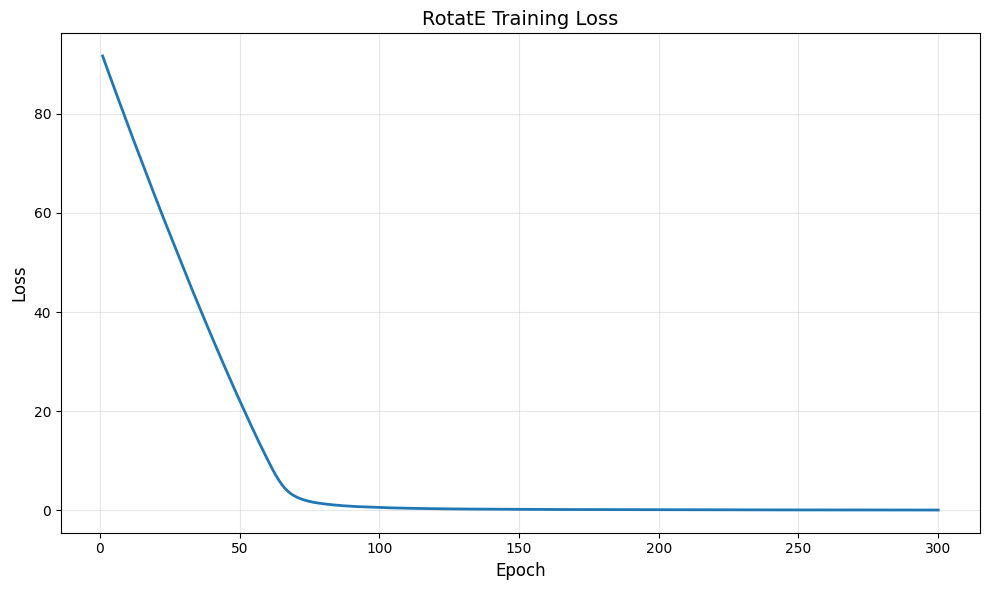

Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]



EVALUATION RESULTS
MRR: 0.7188
Hits@1: 0.5898
Hits@3: 0.8119
Hits@10: 0.9424



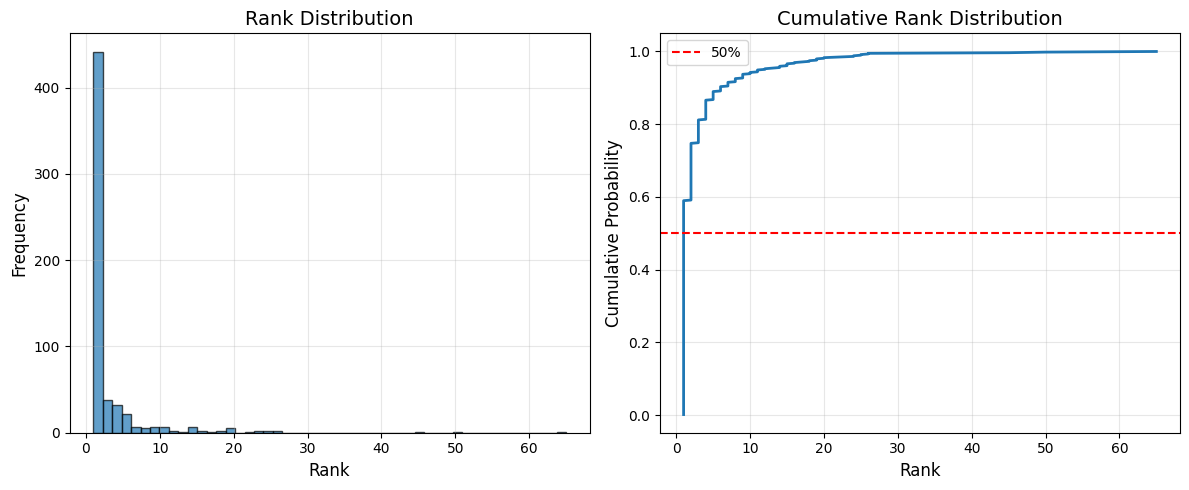

In [90]:
train_triples, test_triples, entity2id, relation2id, id2entity, id2relation = \
        load_data('train.txt', 'test.txt')
train_triples_id = [(entity2id[h], relation2id[r], entity2id[t]) 
                        for h, r, t in train_triples]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RotatE(
        num_entities=len(entity2id),
        num_relations=len(relation2id),
        embedding_dim=100,
        gamma=12.0
    )

losses = train_rotate(
        model=model,
        train_triples=train_triples_id,
        num_entities=len(entity2id),
        epochs=300,
        batch_size=1024,
        lr=0.001,
        num_negatives=64,
        device=device
    )

plot_training_loss(losses)
    

torch.save(model.state_dict(), 'rotate_model.pth')
    

all_triples_set = set(train_triples + test_triples)
results = evaluate_rotate(
        model=model,
        test_triples=test_triples,
        entity2id=entity2id,
        relation2id=relation2id,
        all_triples_set=all_triples_set,
        device=device
    )
    
plot_rank_distribution(results['ranks'])


In [91]:
torch.save(model.state_dict(), "rotate_recovered.pth")
print("Model saved")


Model saved


In [92]:
results = evaluate_rotate(
    model=model,
    test_triples=test_triples,
    entity2id=entity2id,
    relation2id=relation2id,
    all_triples_set=set(train_triples + test_triples),
    device=device
)


Evaluating: 100%|██████████| 37/37 [00:07<00:00,  4.81it/s]


EVALUATION RESULTS
MRR: 0.7188
Hits@1: 0.5898
Hits@3: 0.8119
Hits@10: 0.9424



Had to experiment with a lot of hyperparameters and values of other parameters like negative results, number of epochs, learning rate etc. Increasing the learning rate increased the mrr to an extent, while after that it kind of saturated. Increasing the number of epochs progressively increased the mrr, as it should, as the number of iterations over the entire dataset increased. Also had to be careful as to not overfit the model so that it generalizes well.
Gamma=12 acts as a safe threshold (heuristical, taken from google), changing the number of dimensions would affect granularity.